# Initialisations

In [126]:
library(rJava)
library(ggplot2)
library(corrplot)
library(cluster)
library(reshape2)
library(factoextra)
library(xlsx)
library(dtw)
library(rpart.plot)
library(rpart)
theme_set(theme_classic())

Warning message:
"package 'rpart.plot' was built under R version 3.4.3"

# Plot Functions

In [2]:
adenome_boxplot <- function(df, feature_index, title){
  x_axis = colnames(df)[feature_index]
  caption = "Source : ADENOME-PROS"

  g <- ggplot(df, aes("", df[,feature_index]))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle=x_axis,
         caption=caption,
         x=x_axis,
         y="")
  print(g)
}

adenome_boxplot_couple <- function(df, feature_1, feature_2, f1, f2){
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  caption = "Source : ADENOME-PROS"
    
  g <- ggplot(df, aes(x = feature_1, y = feature_2))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle="",
         caption=caption,
         x=x_axis,
         y=y_axis)
    
  print(g)
}

adenome_scatterplot <- function(df, feature_1, feature_2, f1, f2) {
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  caption = "Source : ADENOME-PROS"
  g <- ggplot(df, aes(x=feature_1, y=feature_2))
  g <- g + geom_point()
  g <- g + labs(title=title,y=y_axis,x=x_axis,caption=caption)
  print(g)
}

adenome_barplot <- function(df, feature_index, title) {
  caption = "Source : ADENOME-PROS"
  x_axis = colnames(df)[feature_index]
  g <- ggplot(df, aes(df[,feature_index]))
  g <- g + geom_bar(width = 0.5)
  g <- g + labs(title=title, 
         subtitle=x_axis,
         caption=caption,
         x=x_axis,
         y="")
  print(g)
}

adenome_piechart <- function(df, feature_index, title){
  bar <- ggplot(vapor, aes(x="", fill = factor(df[,feature_index]))) + geom_bar(width = 1)
  pie <- bar + coord_polar(theta = "y")
  print(pie)
}

# Obtenir le triangle inférieur d'une matrice
get_lower_tri <- function(mat){
    mat[upper.tri(mat)] <- NA
    return(mat)
}

# Obtenir le triangle supérieur d'une matrice
get_upper_tri <- function(mat){
    mat[lower.tri(mat)] <- NA
    return(mat)
}

# Re-ordonne la matrice de corrélation
reorder_cormat <- function(cormat){
    # Utiliser la corrélation entre les variables
    # comme mesure de distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <- cormat[hc$order, hc$order]
}

adenome_heatmap <- function(cormat) { 
    # Reordonner la matrice de corrélation
    cormat <- reorder_cormat(cormat)
    upper_tri <- get_upper_tri(cormat)
    # Fondre la matrice de corrélation
    melted_cormat <- melt(upper_tri, na.rm = TRUE)
    # Créer le heatmap
    ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
        midpoint = 0, limit = c(-1,1), space = "Lab",
        name="Pearson\nCorrelation") +
        theme_minimal()+ # minimal theme
        theme(axis.text.x = element_text(angle = 45, vjust = 1, 
        size = 12, hjust = 1))+
        coord_fixed()
    
ggheatmap <- ggheatmap + 
    geom_text(aes(Var2, Var1, label = round(value,3)), color = "black", size = 3) +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))
    
    # Afficher heatmap
    print(ggheatmap)
}

# Cleanup & Data Preparation

# Pré-traitements


# Préparation des datasets

In [384]:
# import du fichier complet
vapor <- read.xlsx(file = "datasets/VAPOR.xlsx", sheetIndex = 1, header = 1, startRow = 2)[,-1]
attributes(vapor)$names = c('Age','Comorbidite','Duree_Traitement_Medical','Porteur_Sonde','IPSS','QoL','Qmax','PSA','Volume_Prostatique','Residu_post_mictionnel','Indication','Anesthesie','Evenement','Technique','Transfusion','Temps_Operation','Volume_Reseque','Delai_Ablation','Caillotage','Reprise_Bloc',
    'X1M_IPSS','X1M_QoL','X1M_Qmax','X3M_IPSS','X3M_QoL','X3M_Qmax','X6M_IPSS','X6M_QoL','X6M_Qmax','X9M_IPSS','X9M_QoL','X9M_Qmax','X12M_IPSS','X12M_QoL','X12M_Qmax','X15M_IPSS','X15M_QoL','X15M_Qmax','X18M_IPSS','X18M_QoL','X18M_Qmax')

# Cast des variables booléennes
vapor$Comorbidite<-as.logical(vapor$Comorbidite)
vapor$Porteur_Sonde<-as.logical(vapor$Porteur_Sonde)
vapor$Transfusion<-as.logical(vapor$Transfusion)
vapor$Caillotage<-as.logical(vapor$Caillotage)
vapor$Reprise_Bloc<-as.logical(vapor$Reprise_Bloc)

# Cast des variables catégoriques
vapor$Indication<-as.factor(vapor$Indication)
vapor$Anesthesie<-as.factor(vapor$Anesthesie)
vapor$Evenement<-as.factor(vapor$Evenement)
vapor$Technique<-as.factor(vapor$Technique)

# Cast des variables catégoriques ordonnées
vapor$QoL<-as.ordered(vapor$QoL)
vapor$X1M_QoL<-as.ordered(vapor$X1M_QoL)
vapor$X3M_QoL<-as.ordered(vapor$X3M_QoL)
vapor$X6M_QoL<-as.ordered(vapor$X6M_QoL)
vapor$X9M_QoL<-as.ordered(vapor$X9M_QoL)
vapor$X12M_QoL<-as.ordered(vapor$X12M_QoL)
vapor$X15M_QoL<-as.ordered(vapor$X15M_QoL)
vapor$X18M_QoL<-as.ordered(vapor$X18M_QoL)
# 20 premières colonnes du dataset -> pré-opératoire et les dernières -> post-opératoire
vapor_pre<-vapor[,1:20]
vapor_post<-vapor[,21:41]

# On crée un dataframe ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
vapor_num <- vapor[,sapply(vapor, function(x) is.numeric(x))]
vapor_num_pre = vapor_num[1:10]
vapor_num_post = vapor_num[11:24]


# 1.Considérations

Pour faire une analyse décriptive complète il faut que tout les champs de toutes les variables soit renseignés. Cependant pour la variable'Residu post mictionnel' certains individus ont des valeurs non renseignée.Deux possibilités se présentent : 
-Supprimer tout les individus ayant la variable non renseignée 
ou 
-Suprimer la varible 'Residu post mictionnel'.
Pour celà il va falloir étudier si la suppression de cette variable n'a aucun impact sur notre étude .

Ainsi on crée une matrice de corrélation sur les varibles numériques de vapor en enlevant les individus ayant un résidu post mictionnel non défini.

[1] 26

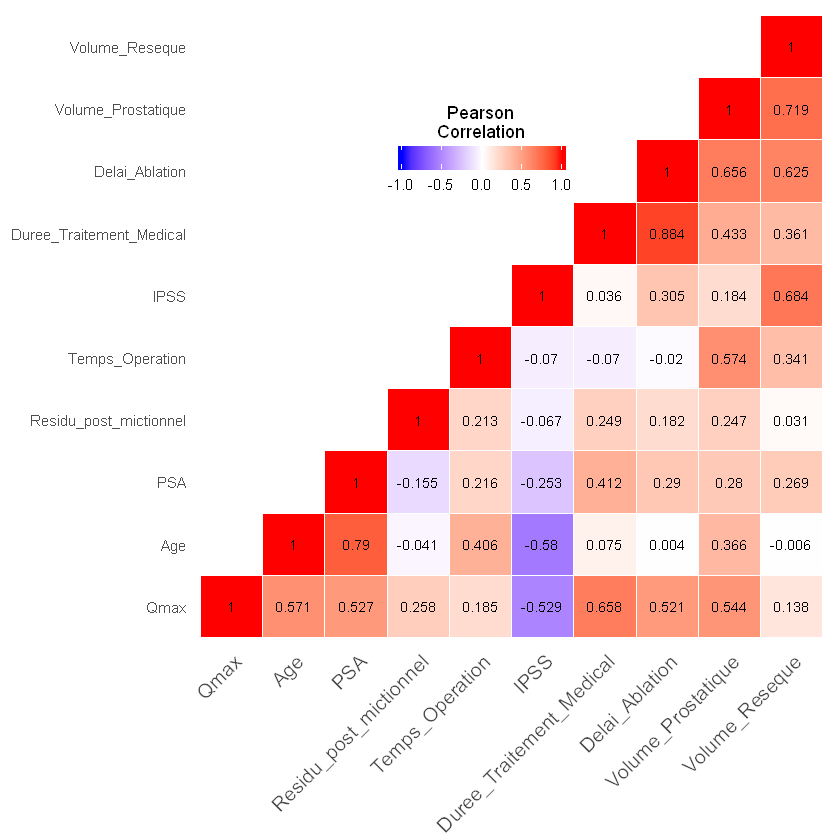

In [385]:
#Faut il garder le résidu post  ou l'enlever ? 
#On enlève tout les individus ayant un résidu post mictionnel=NA
vapor_num_pre_sans= subset(vapor_num_pre[which(vapor_num_pre$Residu_post_mictionnel != ""),])
nrow(vapor_num_pre_sans)
mat_cor_vapoor_num_pre = cor(vapor_num_pre_sans, method = c("pearson"))
adenome_heatmap(mat_cor_vapoor_num_pre )
   


Ainsi en créant une matrice de corrélation sans les individus ayant  le 'Residu post mictionnel' non définit  c-àd on enlève tout les individu porteurs de sonde et on retrouve la matrice de corrélation ci-dessus. On peut déduire que la variable 'Residu post mictionnel' n'est corrélée à aucune autre variable et donc on peut déduire qu'elle peut être une composante intéréssante à garder pour notre étude. On peut également faire une ACP pour confirmer l'intêret de garder cette variable dans notre jeu de données. 

Ainsi on fait une analyse en composantes principales sur les varibles numériques de vapor en enlevant les individus ayant un résidu post mictionnel non défini.

In [386]:

pca <- stats::prcomp(x=subset(vapor_num_pre_sans))
pca

Standard deviations (1, .., p=10):
 [1] 82.3761900 45.3519460 30.8705182 14.1301673  8.7210982  4.5378011
 [7]  1.7928051  0.4590084  0.2340374  0.1108089

Rotation (n x k) = (10 x 10):
                                   PC1         PC2          PC3         PC4
Age                       0.0004453695 -0.02814998  0.040427863 -0.22188161
Duree_Traitement_Medical -0.1738273414 -0.69571824 -0.680800063 -0.05596573
IPSS                      0.0023480168 -0.02318152  0.032575620  0.25394657
Qmax                     -0.0098944784 -0.03081499 -0.011874643 -0.08353452
PSA                       0.0017865406 -0.01767210 -0.004844929 -0.01895752
Volume_Prostatique       -0.1480696991 -0.58726276  0.610579270 -0.35830493
Residu_post_mictionnel   -0.9723380552  0.22679754  0.009450218  0.04962941
Temps_Operation          -0.0370559596 -0.05711579  0.266986419 -0.25107305
Volume_Reseque           -0.0303729499 -0.33667792  0.299036015  0.82572676
Delai_Ablation           -0.0039574939 -0.02134369 -0.

Ainsi en faisant l'ACP on voit clairement que le 'Résidu post mictionnel' a une grande influence sur la PC1 . Ceci nous confirme le fait de devoir garder cette varaible pour la suite de notre étude et de supprimer les individus qui n'en possèdent pas. 

Warning message:
"Removed 14 rows containing non-finite values (stat_boxplot)."

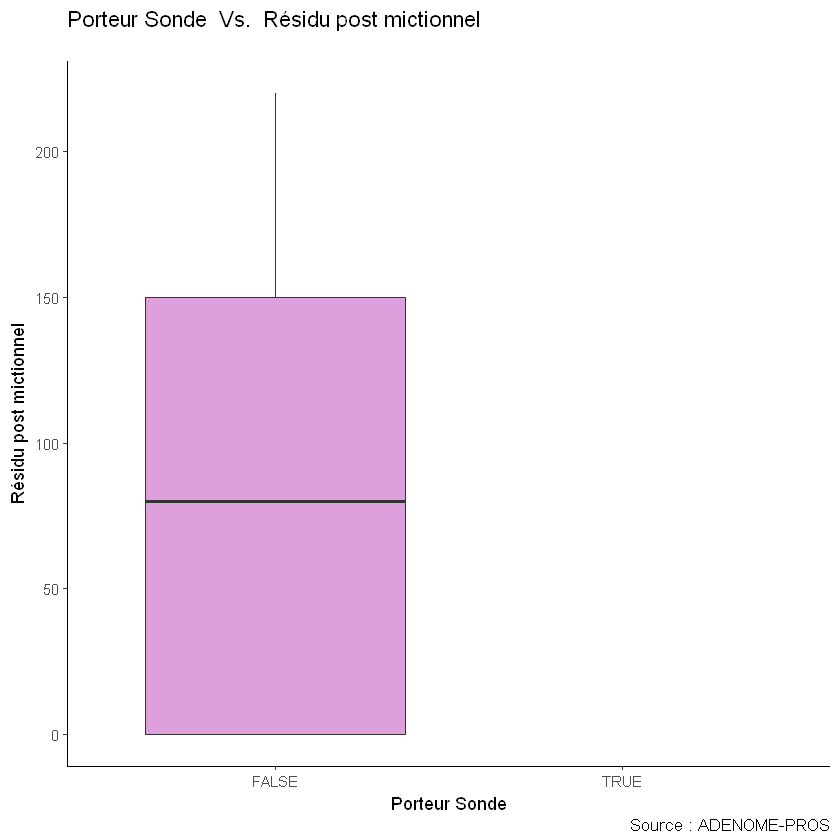

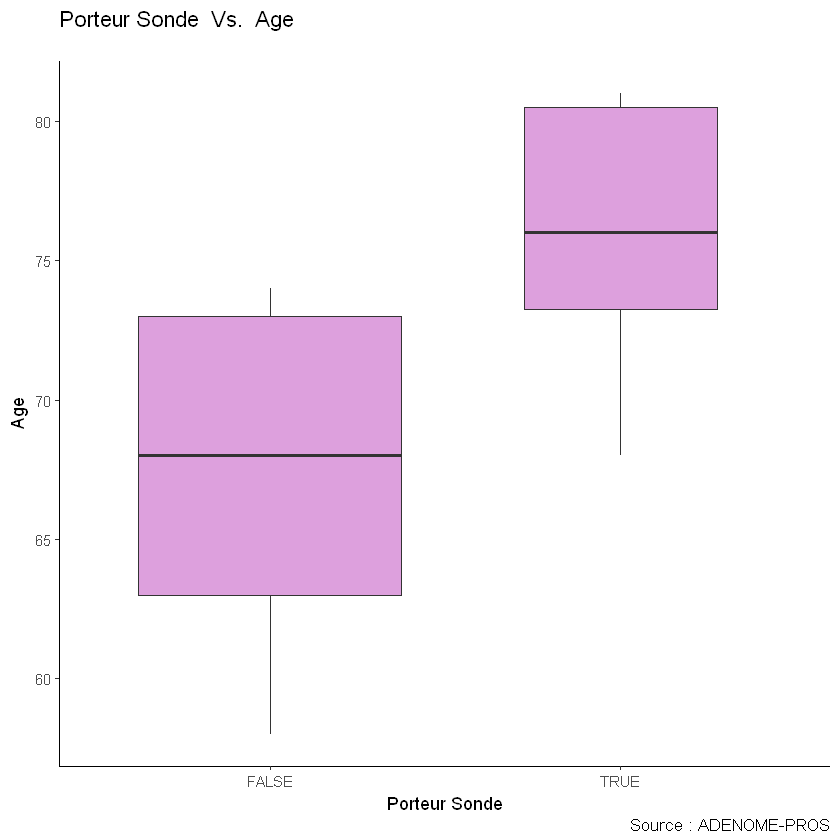

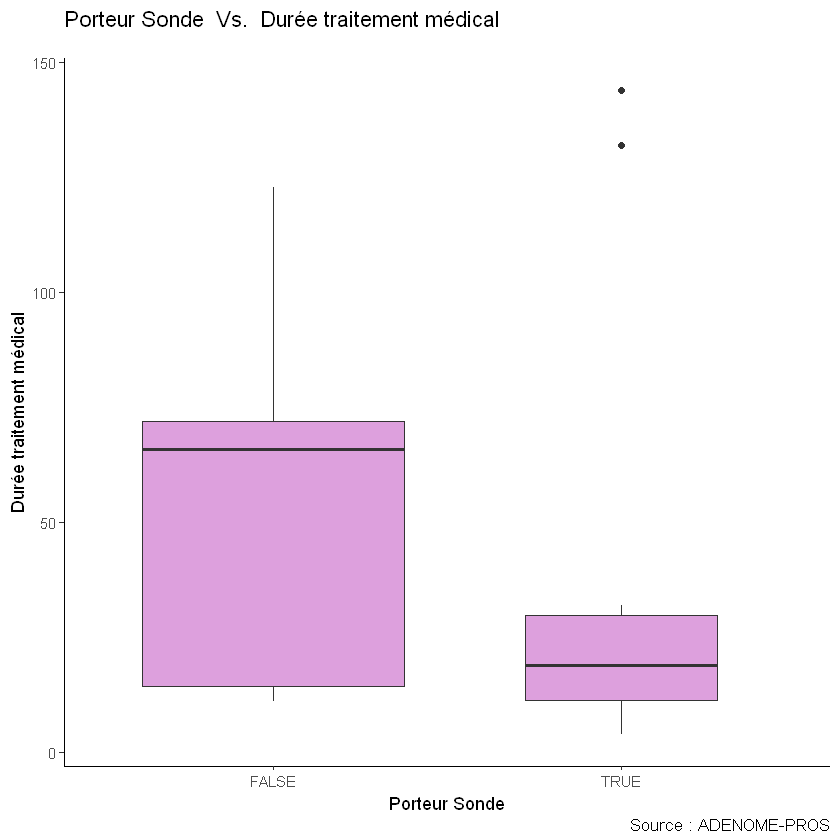

In [387]:
# Quelques distributions par rapport aux porteurs de sondes
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Residu_post_mictionnel, "Porteur Sonde", "Résidu post mictionnel")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Age, "Porteur Sonde", "Age")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Duree_Traitement_Medical, "Porteur Sonde", "Durée traitement médical")

Ainsi grace aux boxplots ci-dessus on remarque que les individus porteurs de sonde sont  les plus agés.Mais aussi que les porteurs de sonde ont un traitement moins long.On peut donc déduire que la variable porteur de sonde est trés corrélée à la variable age et durée de tratement.Cepedant la supression de cette variable ne va pas influencer notre étude.

# 1. Analyse Descriptive
## 1.1 Pré-opératoire
### 1.1.1 Distributions


Ainsi on fait le choix de supprimer tout les individus porteurs de sonde car les variable 'Residu post mictionnel' est non défini. On supprime également la varible 'technique' car elle est représenté par la même valeur chez tout les individus ainsi cette variable n'apporte pas grand chose à notre jeu de données.

In [388]:

vapor=vapor[which(vapor$Porteur_Sonde == FALSE),]
vapor= subset(vapor,select=-c(Porteur_Sonde,Technique))
# 20 premières colonnes du dataset sont donnees pré-opératoire et les dernièrespost-opératoire
vapor_pre<-vapor[,1:18]
vapor_post<-vapor[,19:39]
# On crée un dataframe ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
vapor_num <- vapor[,sapply(vapor, function(x) is.numeric(x))]
vapor_num_pre = vapor_num[1:10]
vapor_num_post = vapor_num[11:24]

# On crée un dataframe ne comportant que les données booléennes, ordinales ou catégoriques
vapor_cat <- vapor[,sapply(vapor, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
vapor_cat = subset(vapor,select=c(Comorbidite,QoL,Indication,Evenement,Anesthesie,Transfusion,Caillotage,Reprise_Bloc,X1M_QoL,X3M_QoL,X6M_QoL,X9M_QoL,X12M_QoL,X15M_QoL,X18M_QoL))
vapor_cat_pre = vapor_cat[1:8]
vapor_cat_post = vapor_cat[9:15]

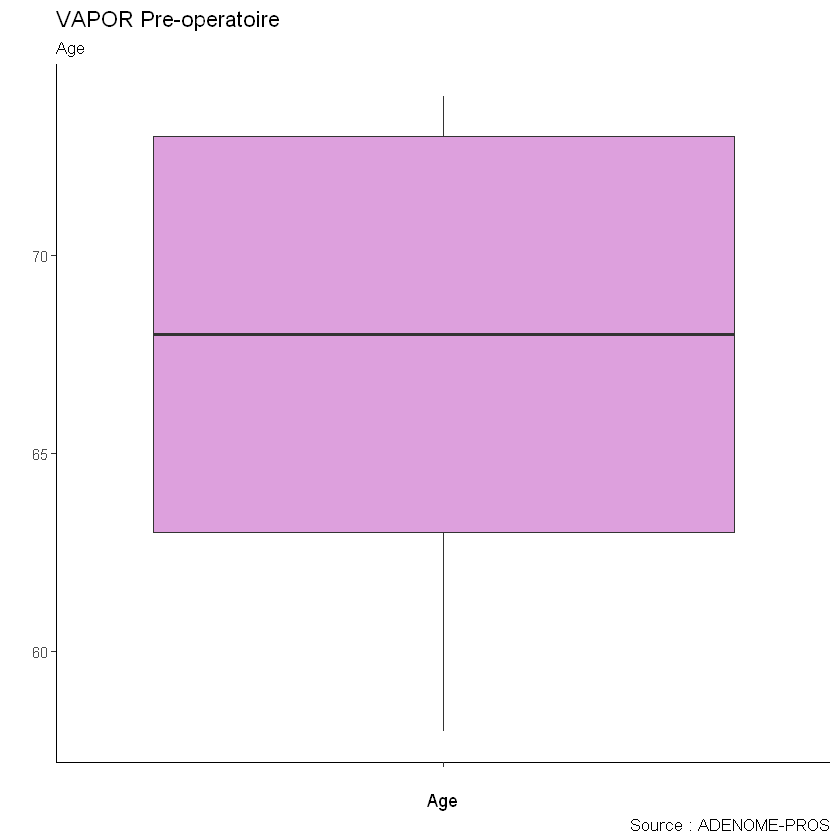

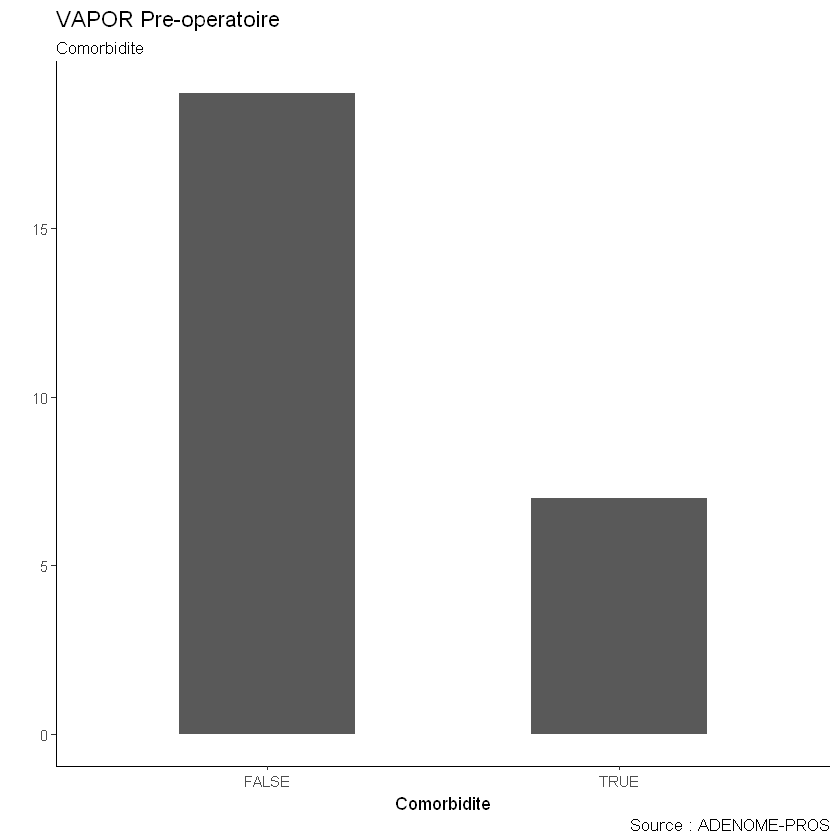

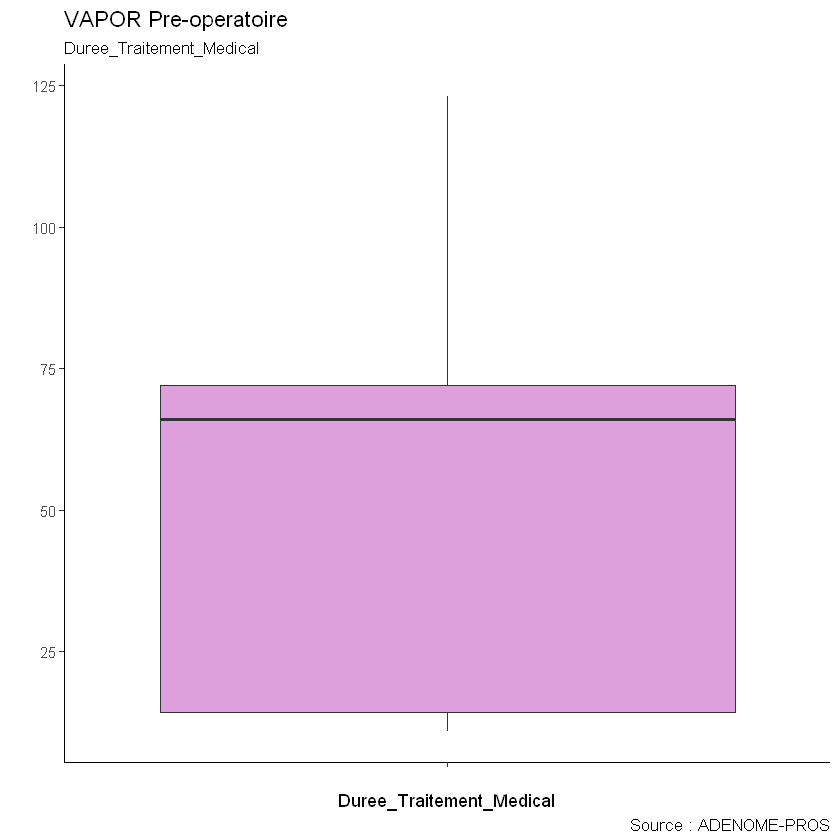

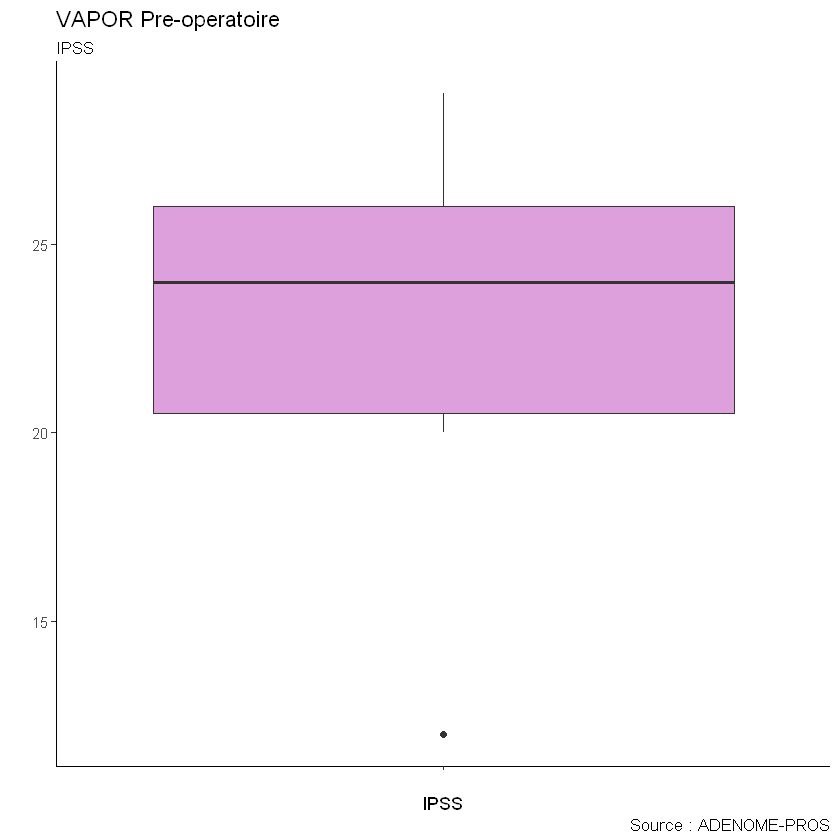

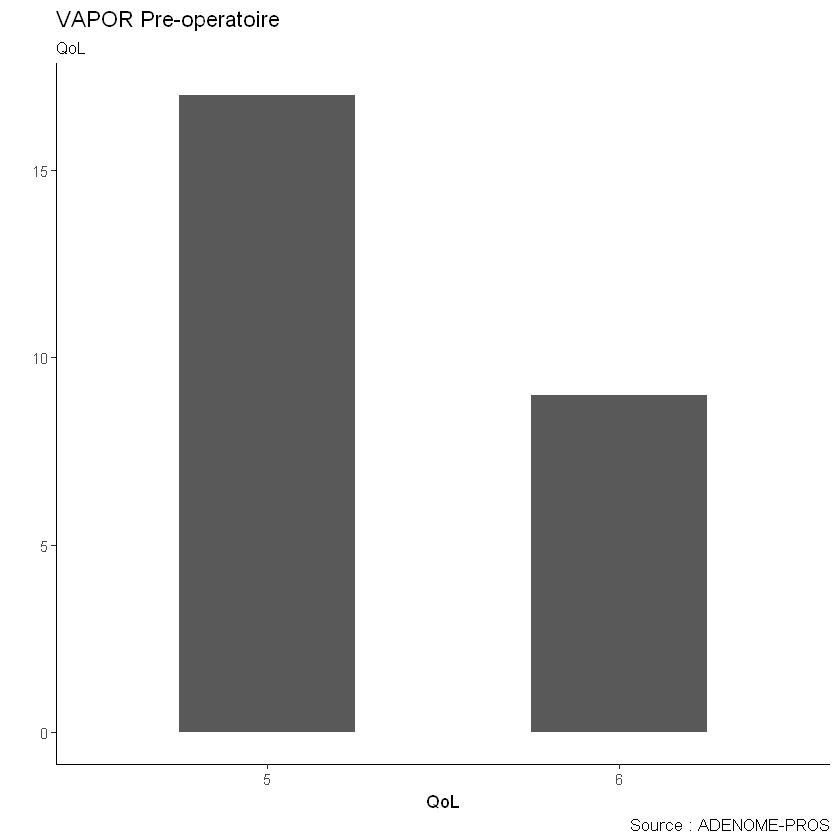

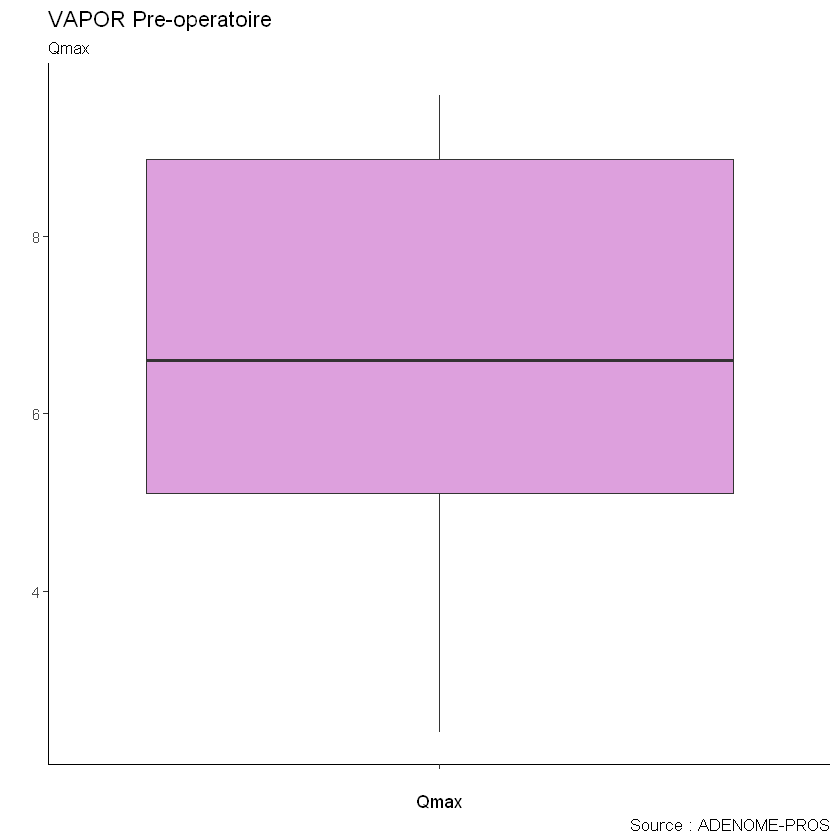

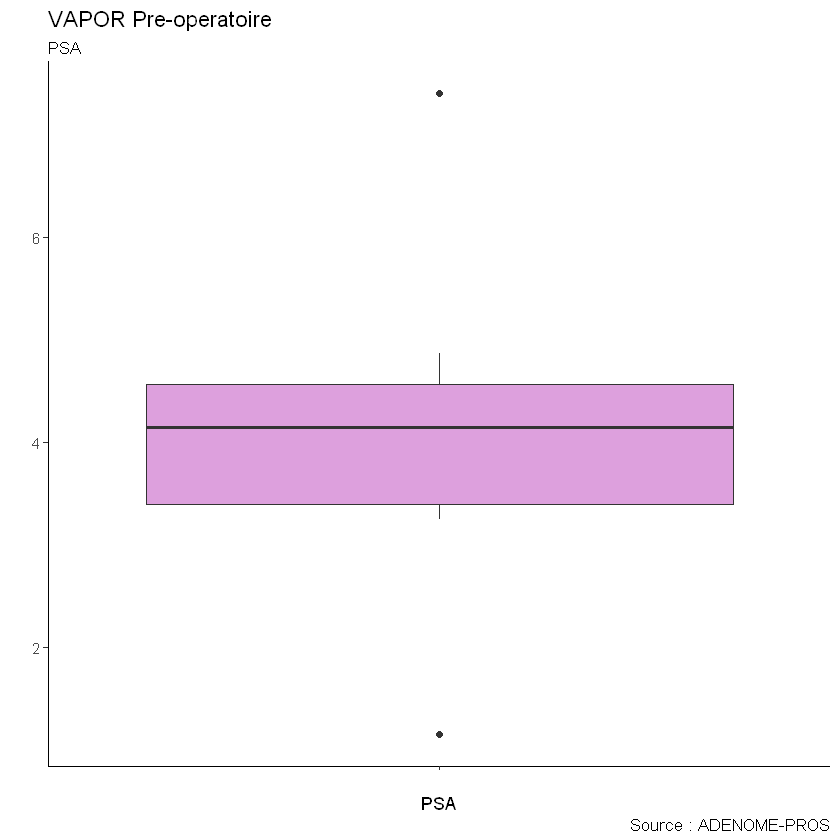

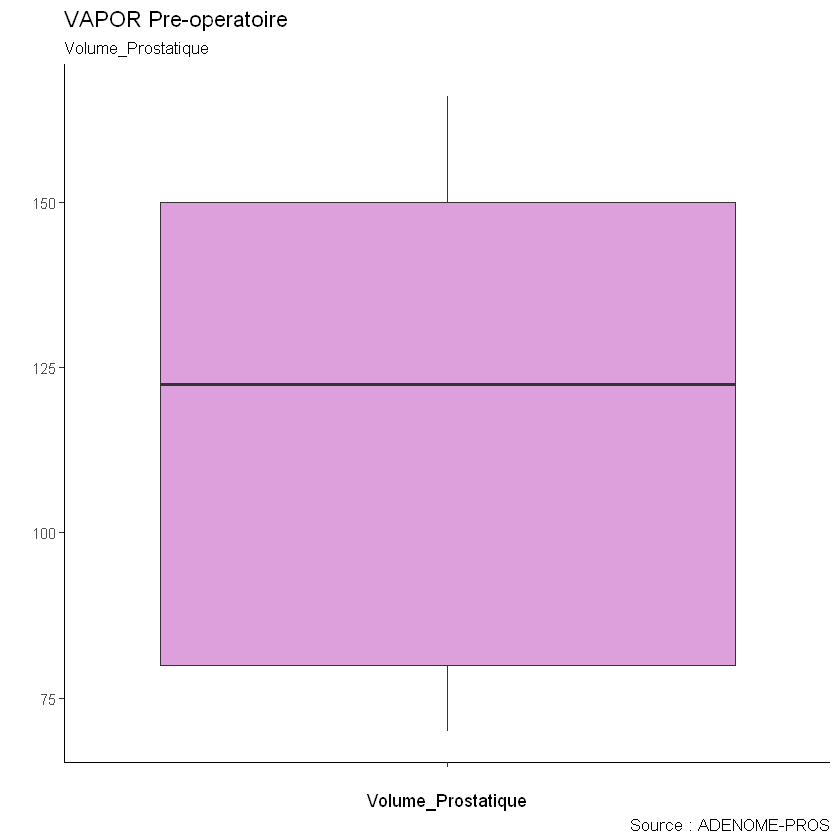

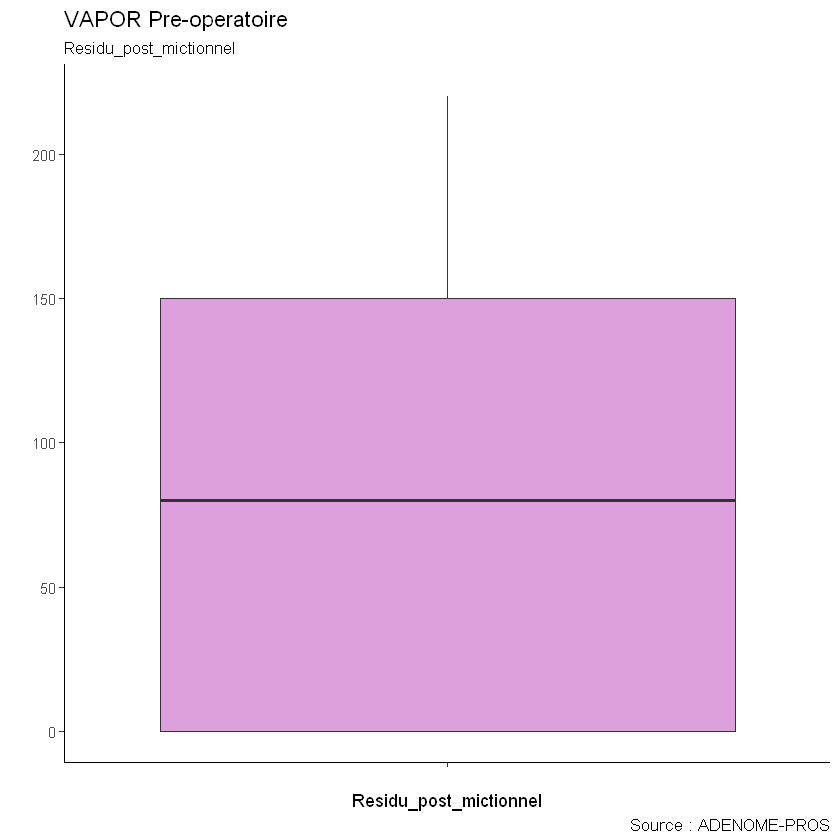

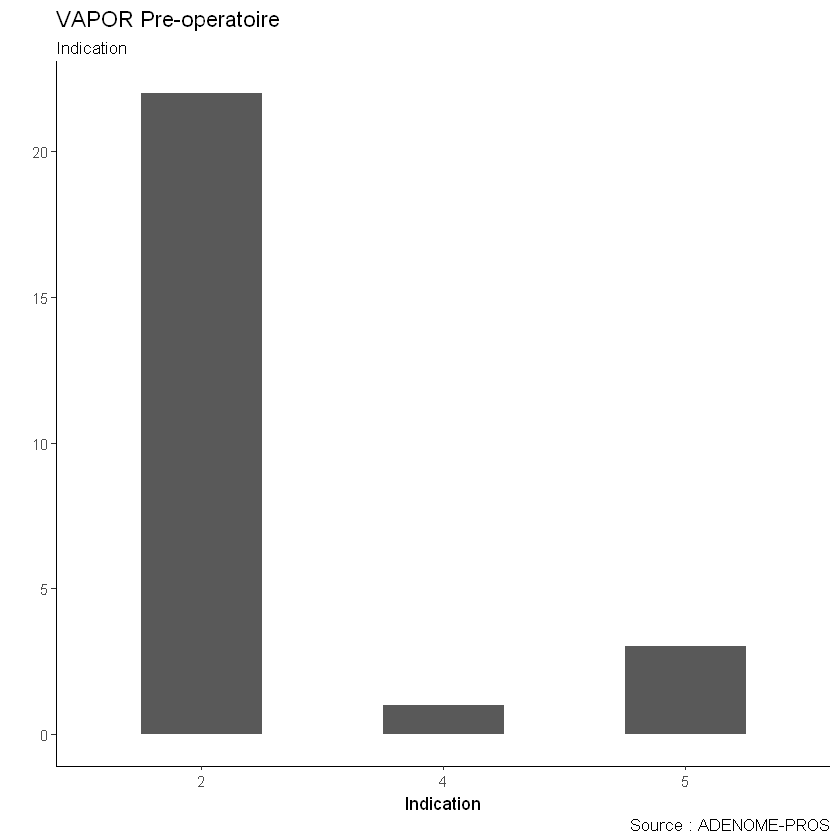

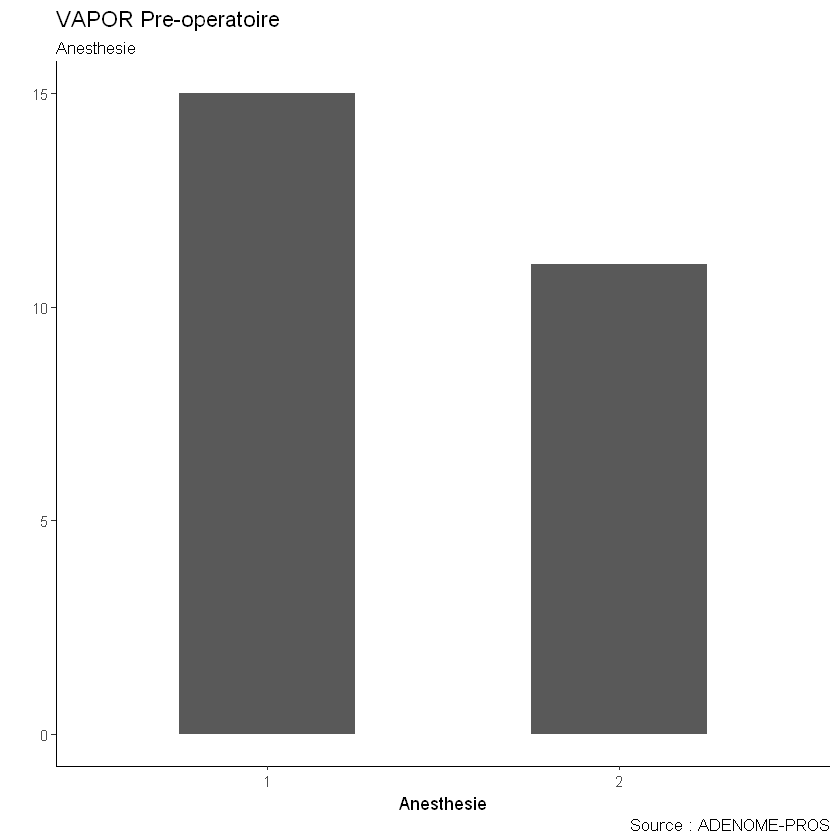

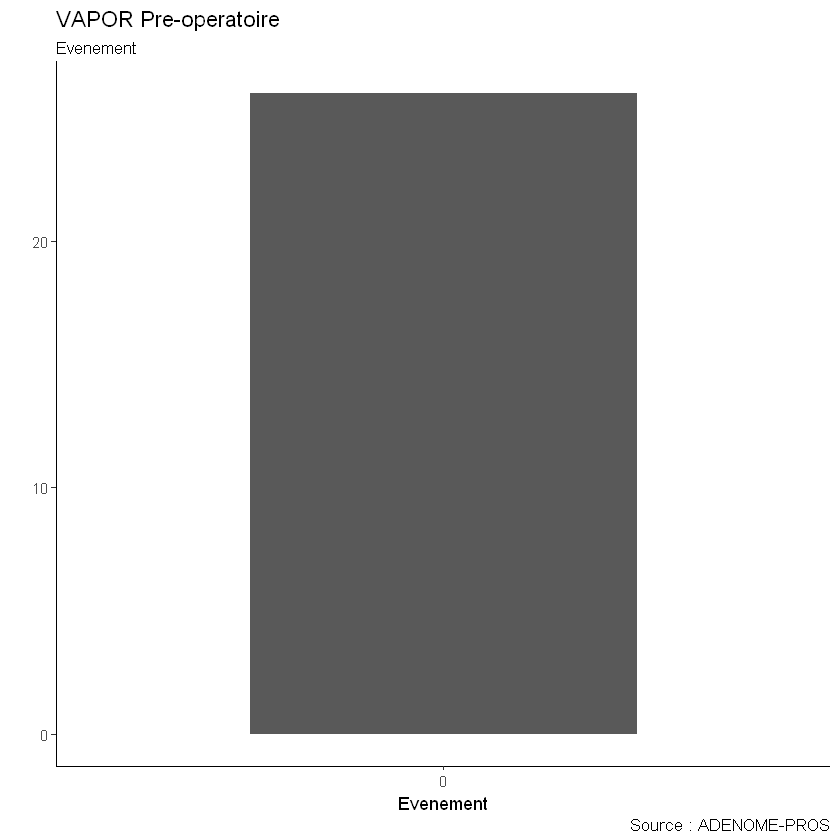

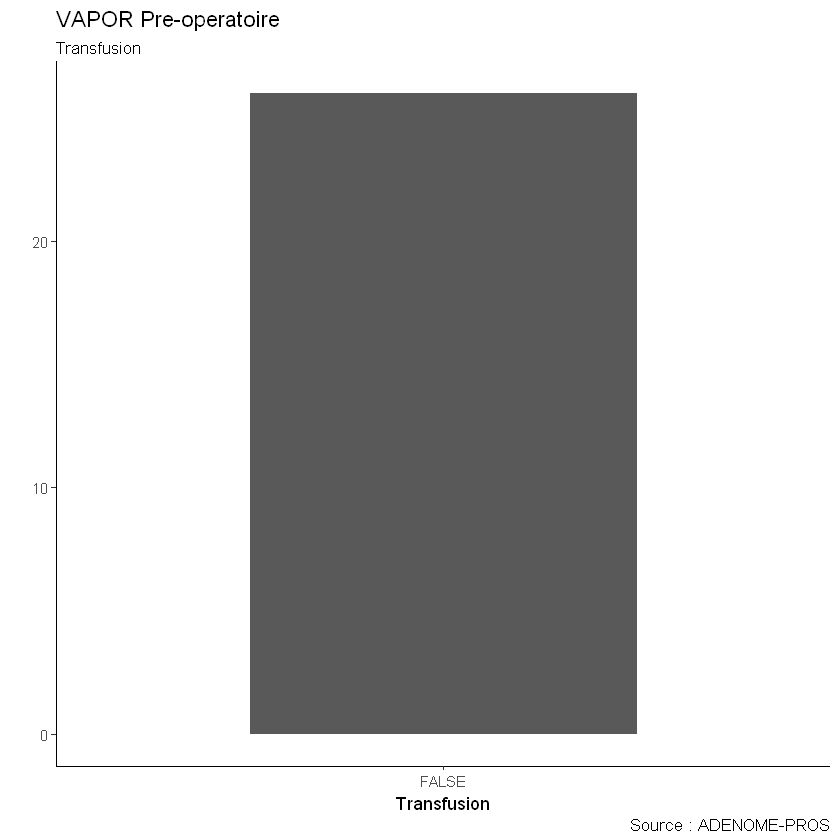

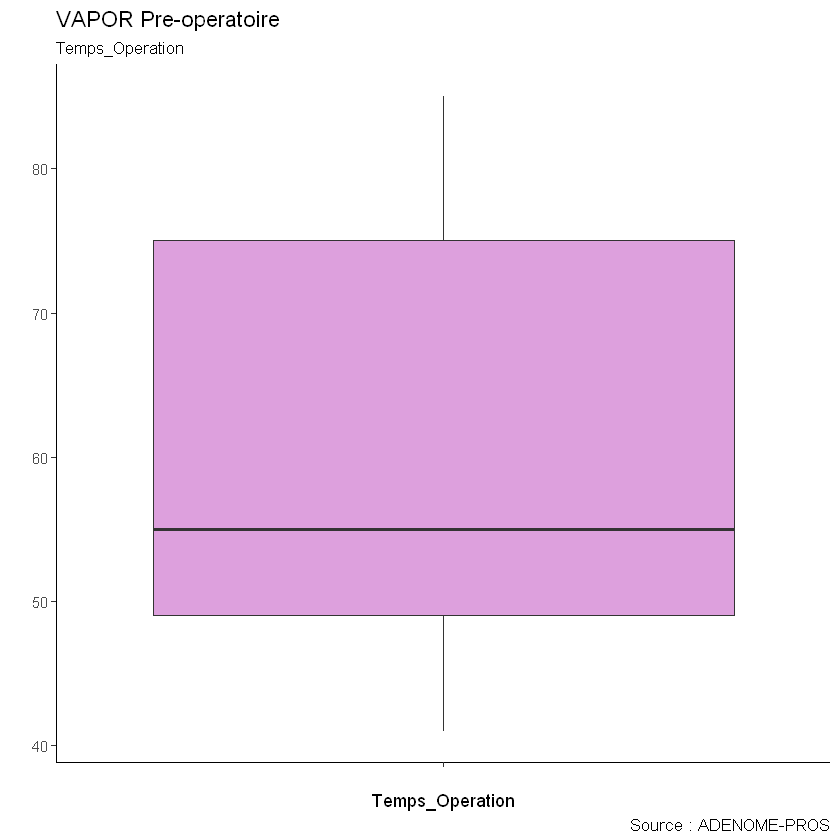

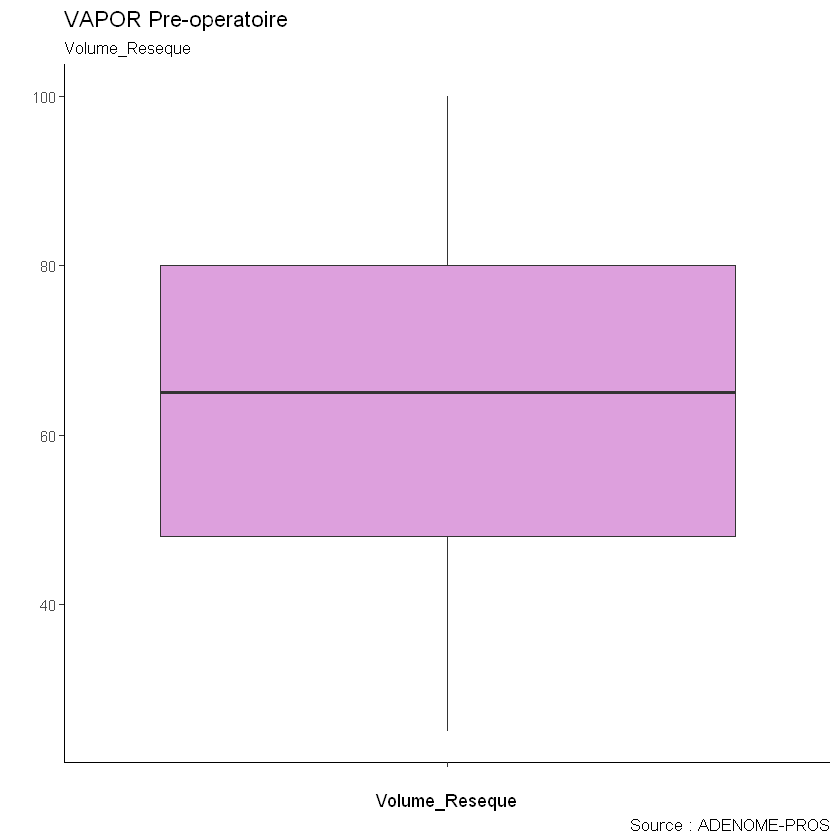

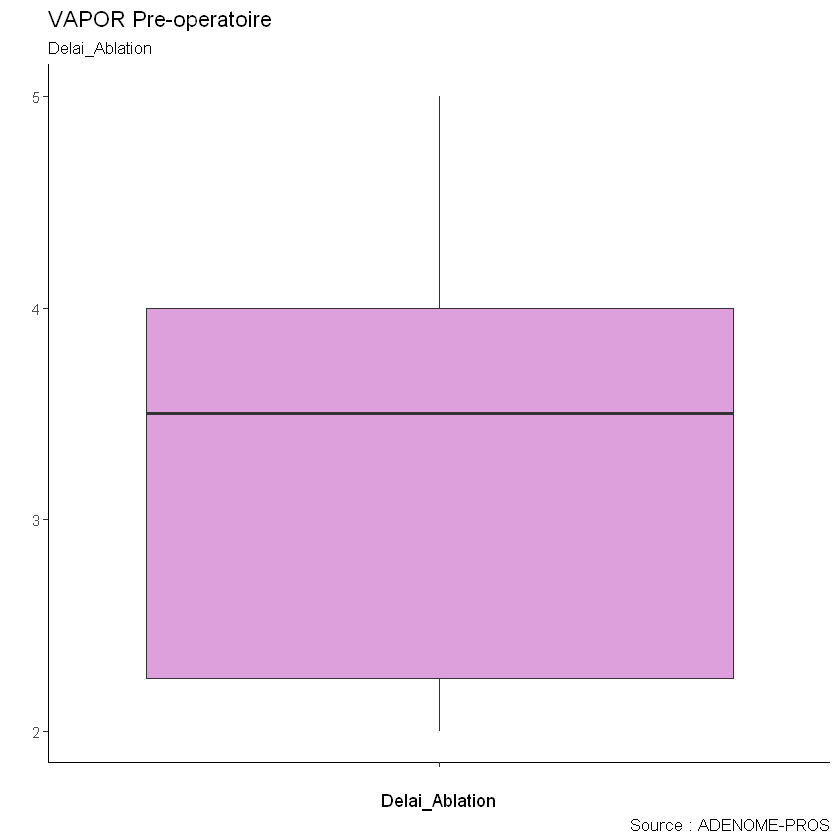

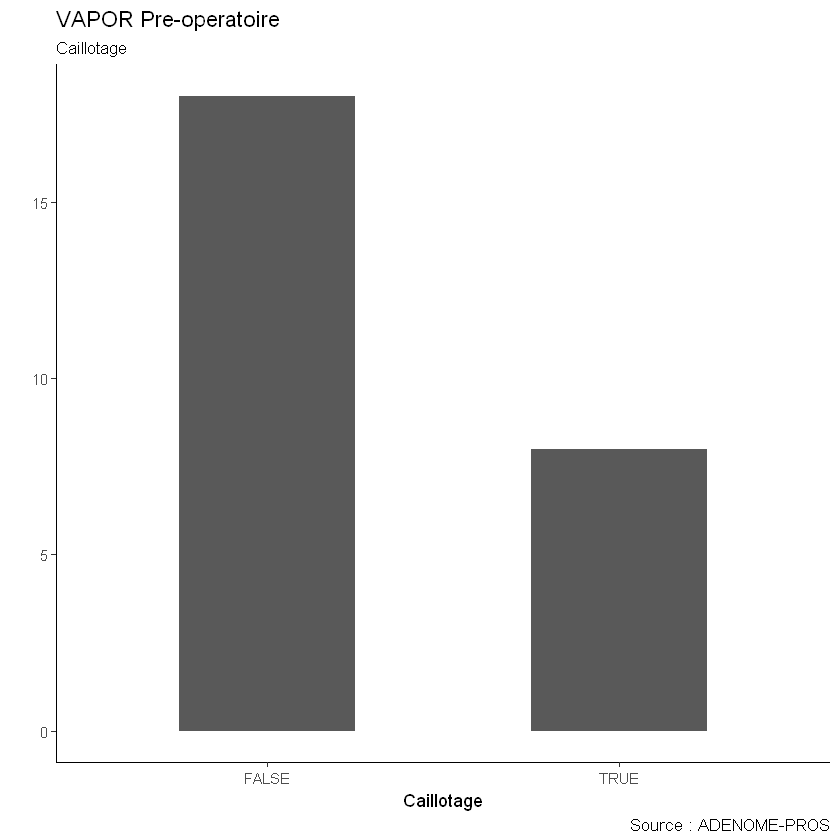

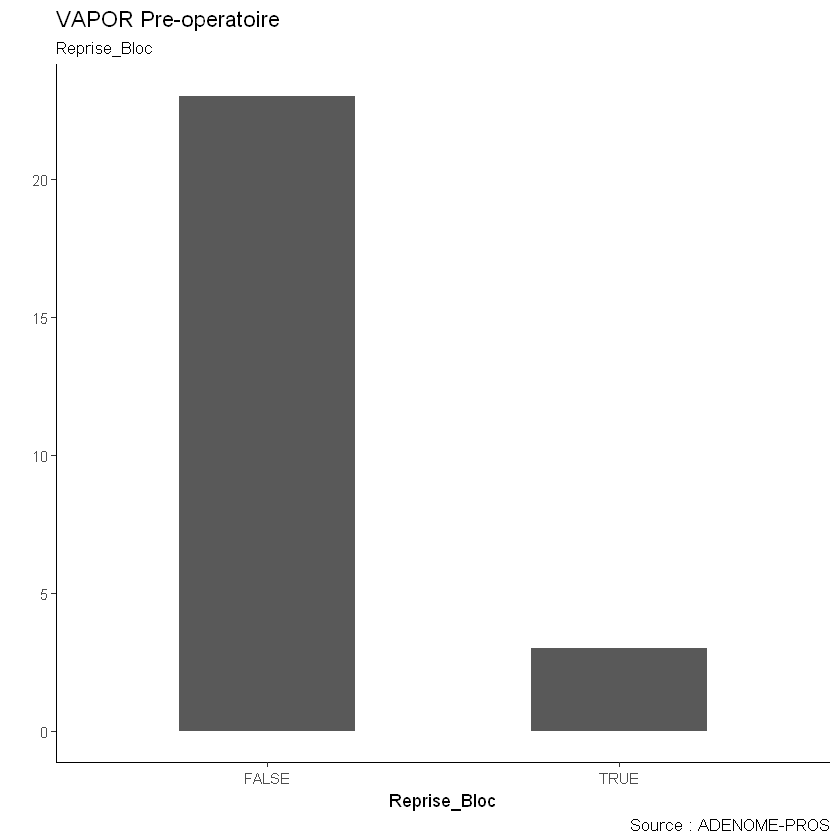

In [389]:
# Boxplots des variables numériques et barplots des variables catégoriques

for (i in 1:ncol(vapor_pre)) {
  #x11(display="")
  if (is.numeric(vapor_pre[,i]) || is.integer(vapor_pre[,i])) {
    adenome_boxplot(vapor_pre,i,"VAPOR Pre-operatoire")
  }
  else
    adenome_barplot(vapor_pre,i,"VAPOR Pre-operatoire")
}

### 1.1.2 Corrélations Heatmap

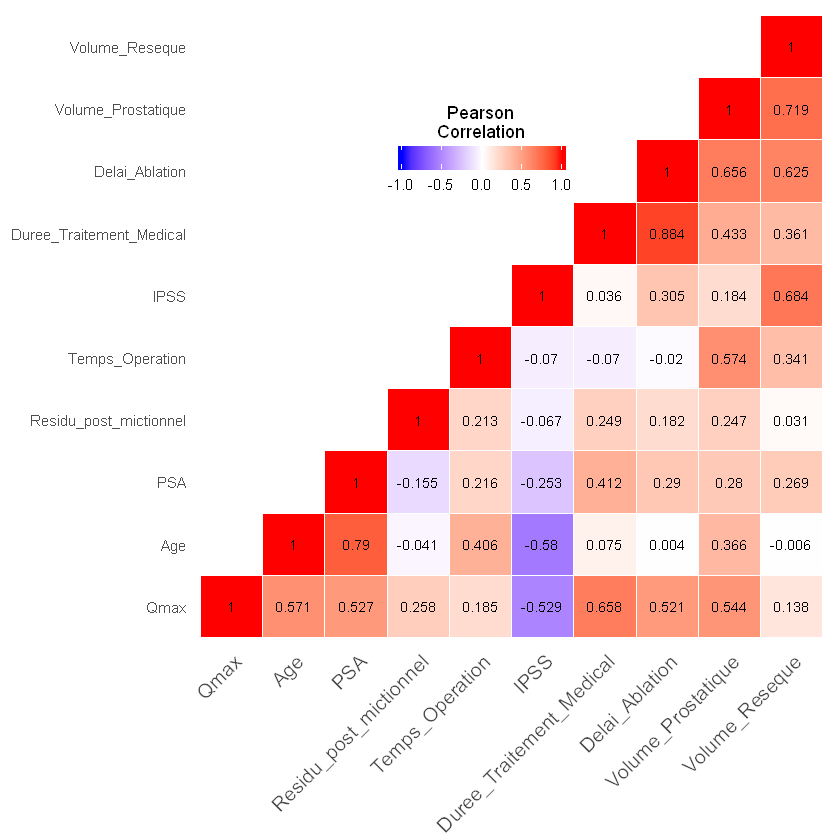

In [9]:
mat_cor_vapor_num_pre = cor(vapor_num_pre, method = c("pearson"))
adenome_heatmap(mat_cor_vapor_num_pre)

Pour la technique VAPOR, en pré-opératoire, nous notons une corrélation entre le "Volume Résequé" et le "Volume prostatique" ainsi qu'une corrélation négative entre "QMax"" et "IPSS". Plus la miction est bonne, plus la gêne est faible.
Dans une moindre mesure, nous notons une corrélation entre "Volume prostatique" et les variables suivantes :
- Temps OP
- Délai Ablation

Nous notons enfin une corrélation entre "Durée Traitement Médical" et "Délai Ablation".

Ces corrélations peuvent être confirmées par les Scatterplots ci-dessous.

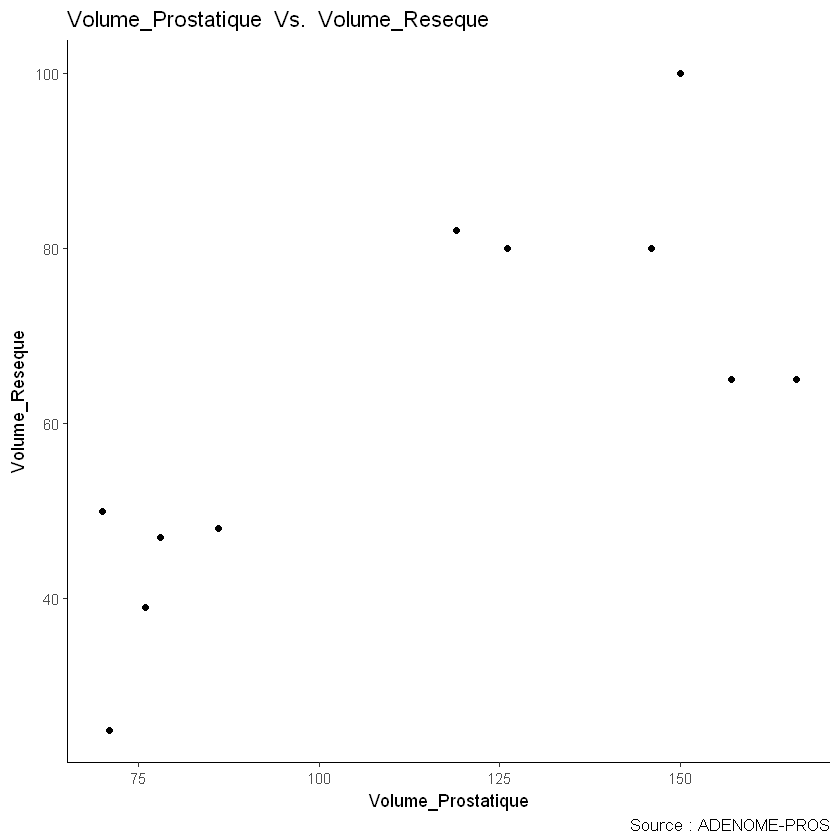

ERROR: Error: Aesthetics must be either length 1 or the same as the data (26): x, y


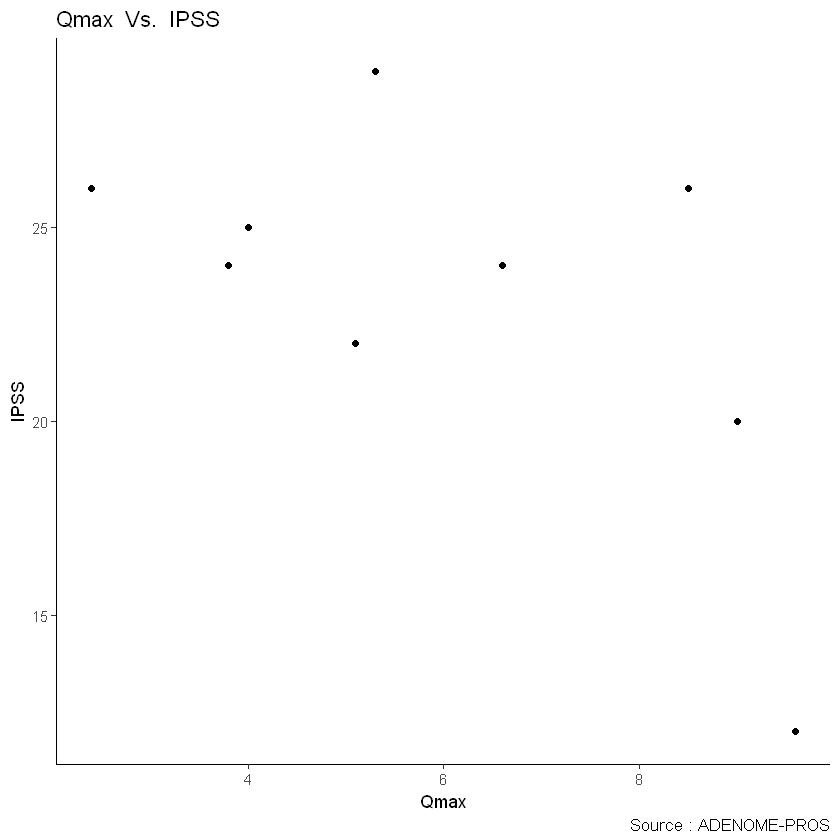

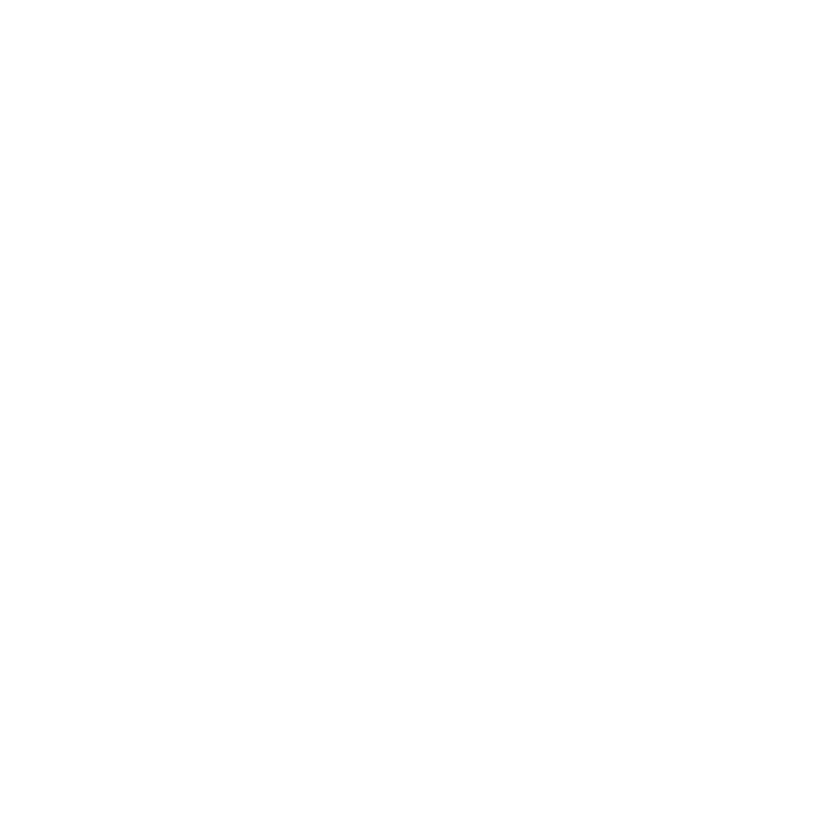

In [10]:
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Volume_Reseque,"Volume_Prostatique","Volume_Reseque")
adenome_scatterplot(vapor_pre,vapor_pre$Qmax,vapor_pre$IPSS,"Qmax","IPSS")
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Tmps_OP,"Volume_Prostatique","Tmps_OP")
adenome_scatterplot(vapor_pre,vapor_pre$Delai_ablation,vapor_pre$Volume_Prostatique,"Delai_ablation","Volume_Prostatique")
adenome_scatterplot(vapor_pre,vapor_pre$Duree_Traitement_Medical,vapor_pre$Delai_ablation,"Duree_Traitement_Medical","Delai_Ablation")

### 1.1.3 Analyse en composantes principales

Nous procédons à une annalyse en composante principale afin de repérer les variables les plus reprèsentatives de nos individus.

In [319]:

pca <- stats::prcomp(x=subset(vapor_num_pre))
summary(pca)

Importance of components%s:
                           PC1     PC2     PC3      PC4     PC5     PC6     PC7
Standard deviation     82.3762 45.3519 30.8705 14.13017 8.72110 4.53780 1.79281
Proportion of Variance  0.6722  0.2037  0.0944  0.01978 0.00753 0.00204 0.00032
Cumulative Proportion   0.6722  0.8759  0.9703  0.99008 0.99761 0.99965 0.99997
                           PC8     PC9   PC10
Standard deviation     0.45901 0.23404 0.1108
Proportion of Variance 0.00002 0.00001 0.0000
Cumulative Proportion  0.99999 1.00000 1.0000

In [320]:
sum(100 * (pca$sdev^2)[1:3] / sum(pca$sdev^2))

[1] 97.03031

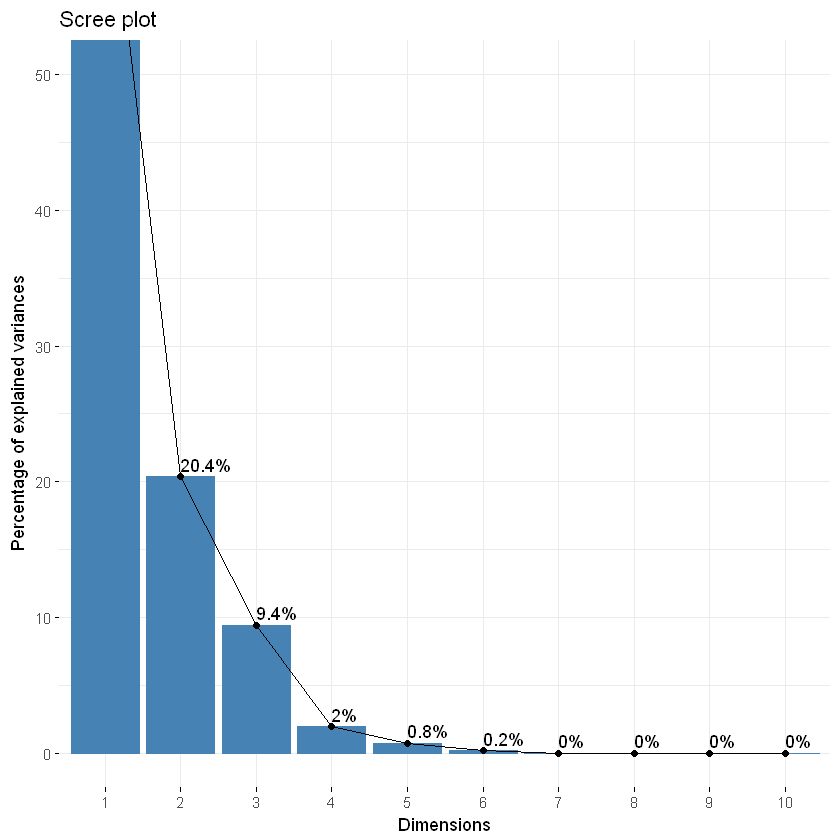

In [321]:
library(factoextra)
fviz_eig(pca, addlabels = TRUE, ylim = c(0, 50))

Ainsi  d'après le graphe ci-dessus et d'aprés la valeur de la proportion cumulative on peut déduire que les troiss premières composantes sont les plus représentatives. En effet ces composantes à elles seules contiennent 97.03% de l'information, il est donc raisonnable de garder seulement ces trois varibles.

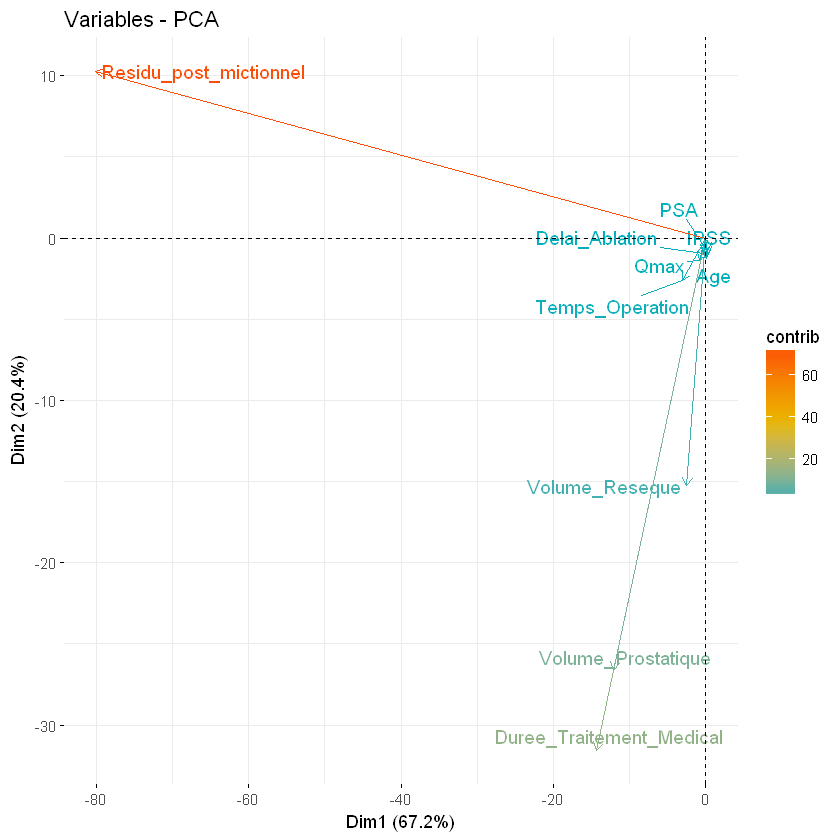

In [322]:
library("factoextra")
fviz_pca_var(pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Évite le chevauchement de texte
             )

En observant le graphe ci-dessus on peut déduire que les variables qui contribue le plus dans la PC1 et la PC2  sont les variables: residu post mictionnel, durée de traitement médical, volume prostatique ,volume reseque.

# 1.2 Post-opératoire

### 1.2.1 Distributions

Afin de bien identifier qu'il existe des profils post opératoire différents on choisit 3 individus au hasard parmi le jeu de données post opératoires et en essaye de tracer l'évolution des trois varibles cuivantes:IPSS,QoL et Qmax en fonction du temps.

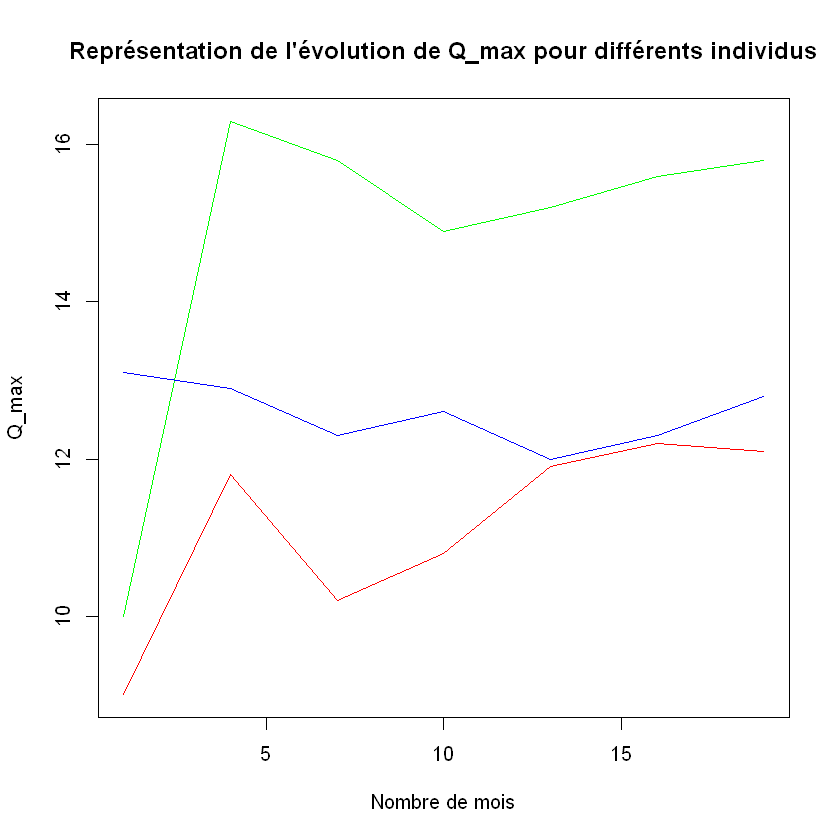

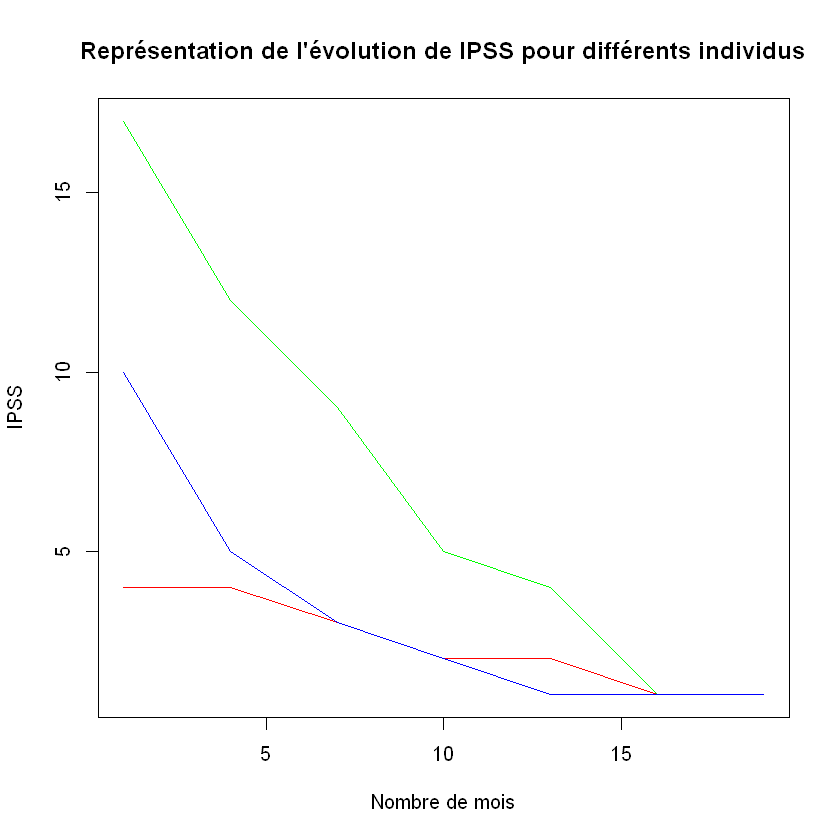

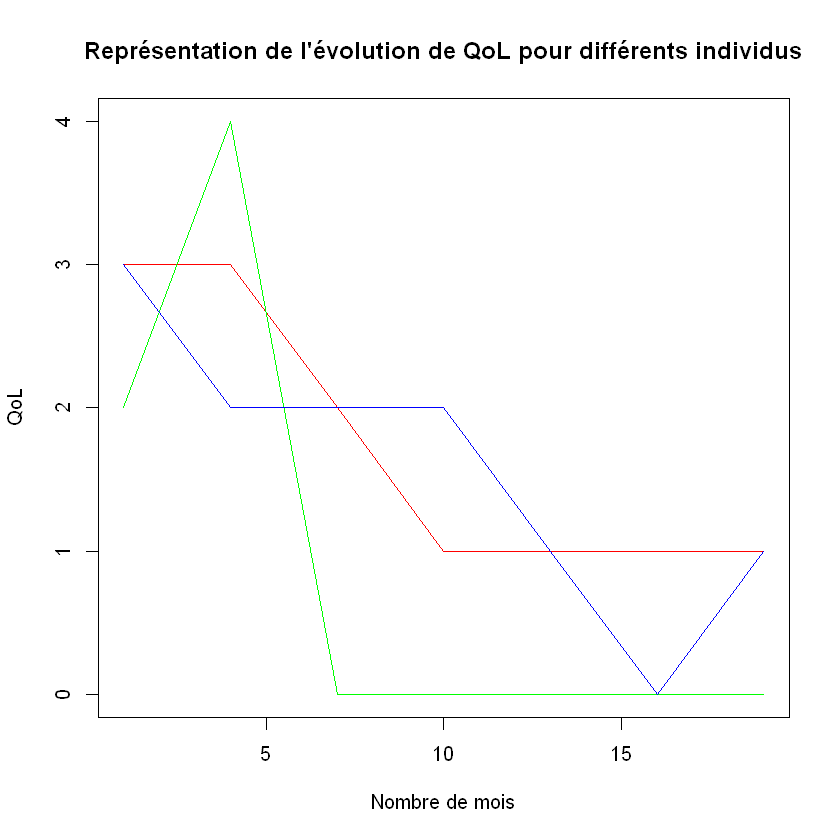

In [391]:
#On choisit trois individus au hazard
require(graphics)
individu= sample(1:nrow(vapor_num_post), 3)
i1=individu[1]
i2=individu[2]
i3=individu[3]
#On crée des séries temporels pour nos variable Q_max ,IPSS et QoL
vapor_num_post_qmax=t(subset(vapor_num_post,select=c(X1M_Qmax,X3M_Qmax,X6M_Qmax,X9M_Qmax,X12M_Qmax,X15M_Qmax,X18M_Qmax)))
vapor_num_post_ipss=t(subset(vapor_num_post,select=c(X1M_IPSS,X3M_IPSS,X6M_IPSS,X9M_IPSS,X12M_IPSS,X15M_IPSS,X18M_IPSS)))
vapor_cat_post_QoL=t(vapor_cat_post)
vapor_num_post_series_qmax=ts(vapor_num_post_qmax, start=1,deltat=3)
vapor_num_post_series_ipss=ts(vapor_num_post_ipss, start=1,deltat=3)
vapor_cat_post_series_QoL=ts(vapor_cat_post_QoL, start=1,deltat=3)

#On plot l'évolution de Q_max pour les 3 individus tirés au sort
Q_max_Individu1=vapor_num_post_series_qmax[,i1]
Q_max_Individu2=vapor_num_post_series_qmax[,i2]
Q_max_Individu3=vapor_num_post_series_qmax[,i3]
Q_max=cbind(Q_max_Individu1,Q_max_Individu2,Q_max_Individu3)
ts.plot(Q_max,gpars= list(col=rainbow(3)),xlab="Nombre de mois",ylab= "Q_max",main="Représentation de l'évolution de Q_max pour différents individus")

#On plot l'évolution de IPSS pour les 3 individus tirés au sort
Ipss_Individu1=vapor_num_post_series_ipss[,i1]
Ipss_Individu2=vapor_num_post_series_ipss[,i2]
Ipss_Individu3=vapor_num_post_series_ipss[,i3]
Ipss=cbind(Ipss_Individu1,Ipss_Individu2,Ipss_Individu3)
ts.plot(Ipss,gpars= list(col=rainbow(3)),ylab= "IPSS",xlab="Nombre de mois",main="Représentation de l'évolution de IPSS pour différents individus")


#On plot l'évolution de Qol pour les 3 individus tirés au sort
QoL_Individu1=vapor_cat_post_series_QoL[,i1]
QoL_Individu2=vapor_cat_post_series_QoL[,i2]
QoL_Individu3=vapor_cat_post_series_QoL[,i3]
QoL=cbind(QoL_Individu1,QoL_Individu2,QoL_Individu3)
ts.plot(QoL,gpars= list(col=rainbow(3)),xlab="Nombre de mois",ylab= "QoL",main="Représentation de l'évolution de QoL pour différents individus")



Ainsi les différents tracés ci-dessus sont des tracés des séries temporelles des variables pour différents individus.Ces graphes montrent bien qu'il existe un certains nombre de profils différents ici 3 profils différents.On peut même dire qu'on aura un nombre de clusters supérieurs ou égal à 3 .

Ensuite on trace par des boxplot l'evolution de ces trois variables à travers les mois. 

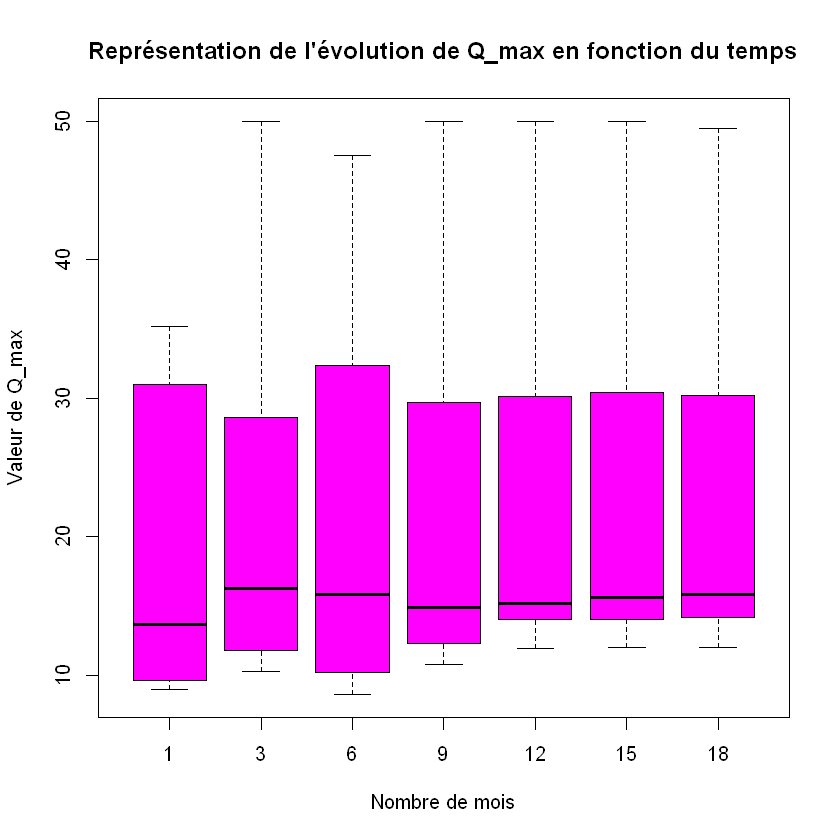

In [330]:
#On trace l'évolution d'IPSS en fonction du temps
Boxplot=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=vapor_num_post$X1M_Qmax[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
Qmax=subset(vapor_num_post,select=c(X3M_Qmax,X6M_Qmax,X9M_Qmax,X12M_Qmax,X15M_Qmax,X18M_Qmax))
for (i in 1:ncol(Qmax)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=Qmax[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="Représentation de l'évolution de Q_max en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de Q_max")

Pour Q_max on remarque qu'après l'opèration le patient voit généralement sont Q_max augmenté au fur et à masure du temps pour stagner par la suite. 


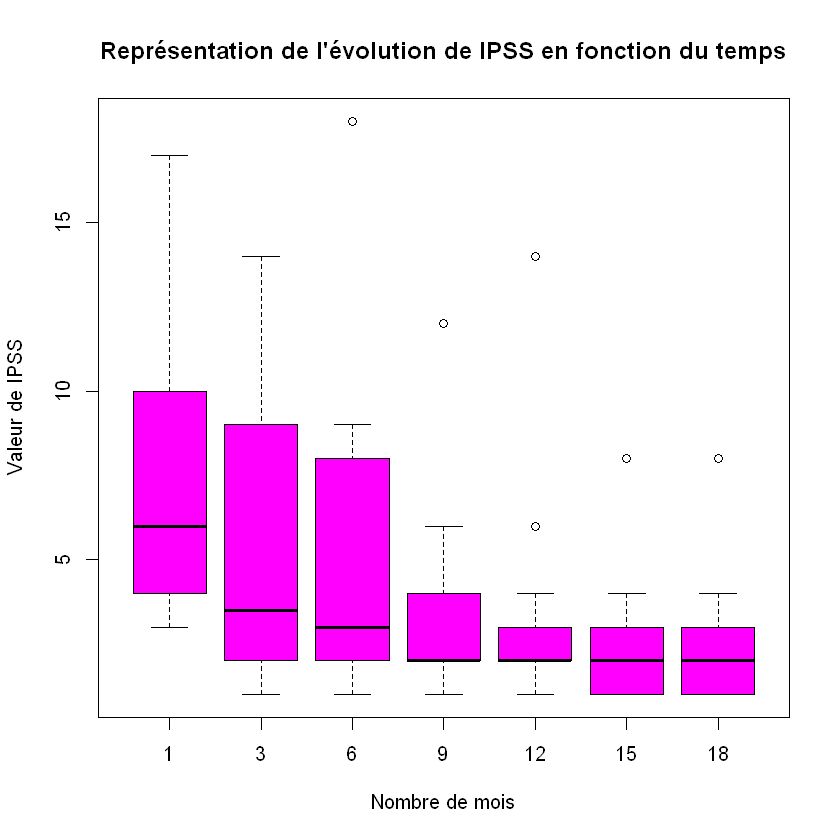

In [332]:
#On trace l'évolution d'IPSS en fonction du temps
Boxplot=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=vapor_num_post$X1M_IPSS[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
ipss=subset(vapor_num_post,select=c(X3M_IPSS,X6M_IPSS,X9M_IPSS,X12M_IPSS,X15M_IPSS,X18M_IPSS))
for (i in 1:ncol(ipss)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=ipss[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="Représentation de l'évolution de IPSS en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de IPSS")


D'aprés les boxplot ci-dessus on remarque que la valeur d'IPSS diminue progressivement après l'opération puis stagne au niveau du 15ième et 18ième mois.En effet cette diminution est logique car après l'opération les symptomes sont sensés disparaitre et le patient se sent de plus en plus mieux.

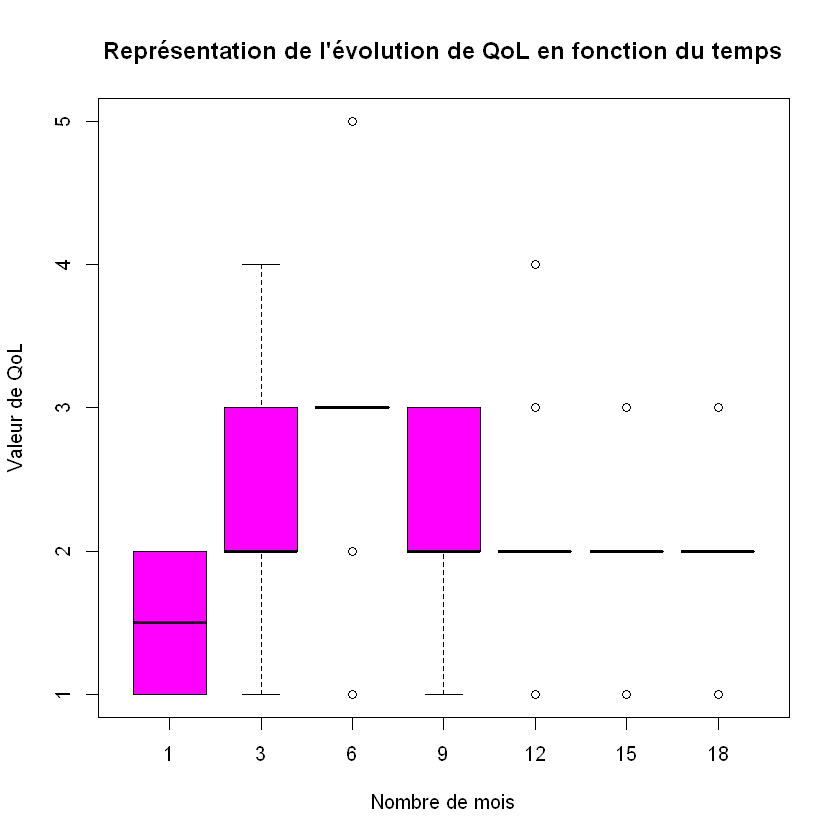

In [199]:
#On trace l'évolution de QoL en fonction du temps
Boxplot=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=vapor_cat_post$X1M_QoL[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
QoL=subset(vapor_cat_post,select=-c(X1M_QoL))
for (i in 1:ncol(QoL)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=QoL[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="Représentation de l'évolution de QoL en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de QoL")


Contrairement à l'IPSS la QoL(Quality of life) augmente progressivement puis se stabilise au bout du 9 ième mois. Cette variable nous indique à quel point l'individu ressent l'amélioration après son opération. Le fait d'avoir l'IPSS et QoL qui évolue inversement vient confirmer la corrélation négative trouvé dans l'analyse descriptive des données pré-opératoires. 

# 2 Clustering des données VAPOR 
## 2.1 Extraction des profils types des patients à partir des données pré-opératoires
### 2.1.1 PAM

Avant de procéder à PAM on peut faire un CMDScale permettant de représenter la dissimilarité entre les individus. Cette représentation peut nous donner un nombre approximatif des clusters pour notre jeu de données.

Warning message in daisy(vapor_pre, metric = c("gower")):
"setting 'logical' variables 2, 13, 17, 18 to type 'asymm'"

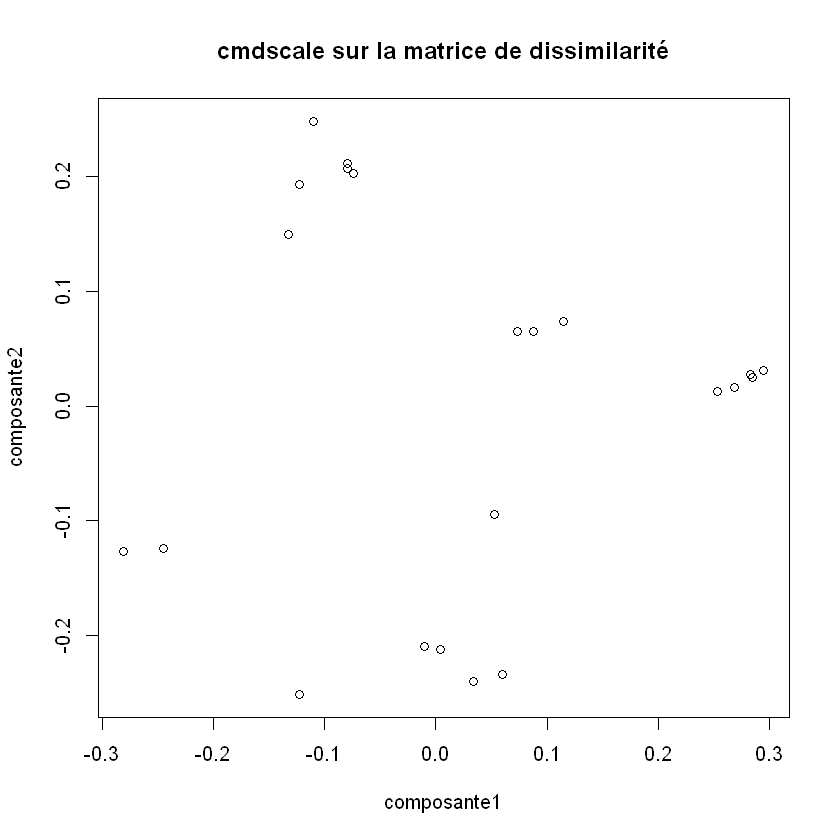

In [333]:
require(cluster)
library(fpc)
#On crée notre matrice de dissimilarité utilisant daisy car matrice hétérogène
disMatrix=daisy(vapor_pre,metric = c("gower"))

cmd=cmdscale(disMatrix,k=2)
plot(cmd[,1],cmd[,2],main="cmdscale sur la matrice de dissimilarité",xlab="composante1",ylab="composante2")

A travers le graphe ci-dessus on peu bien voir qu il existe problablement autour de 6 ou 7 clusters pour notre jeu de données. Pour s'en rassurer on va faire une étude PAM qui va nous valider cette intuition.

In [20]:

#On fait une boucle pour repèrer les 5 meilleurs valeurs de k qui maximise la valeur silhouette
respam<- numeric(20)
for (k in 2:20)
respam[[k]] <- pam(disMatrix,k) $ silinfo $ avg.width
sortrespam=respam[which(respam>0.7)]
sortrespam=sort(sortrespam,decreasing=TRUE)
k.best=c()
for (i in 1:length(sortrespam)){
        k.best[i] <-which(respam[]==sortrespam[i])
}
#On regarde le min de k pour une valeur silhouette supérieur à 0.7
k.min<-min(k.best)
cat("Les 3 meilleurs nombre de clusters sont", k.best[1:3], ".Ayant une valeur silhouette de ",respam[k.best[1:3]],". Le nombre de cluster pour une valeur silhouette maximale est=" ,k.best[1]," . \n")
cat("Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est", k.min, " et ayant un valeur silhouette de ",respam[k.min],"\n")

Les 3 meilleurs nombre de clusters sont 9 8 7 .Ayant une valeur silhouette de  0.8127144 0.7950656 0.7544874 . Le nombre de cluster pour une valeur silhouette maximale est= 9  . 
Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est 6  et ayant un valeur silhouette de  0.7395041 



Ainsi d'après cette comparaison on peut très bien voir que le nombre optimal de clusters à choisir est de 6. En effet cette valeur parait assez correcte vu   qu 'elle propose une valeur silhouette de 0.74 qui n'est pas trés loin de la valeur maximale qui est de 0.81 et qui propose des clusters d'une moyenne de 4 individus.

In [21]:
k.optimal=k.min

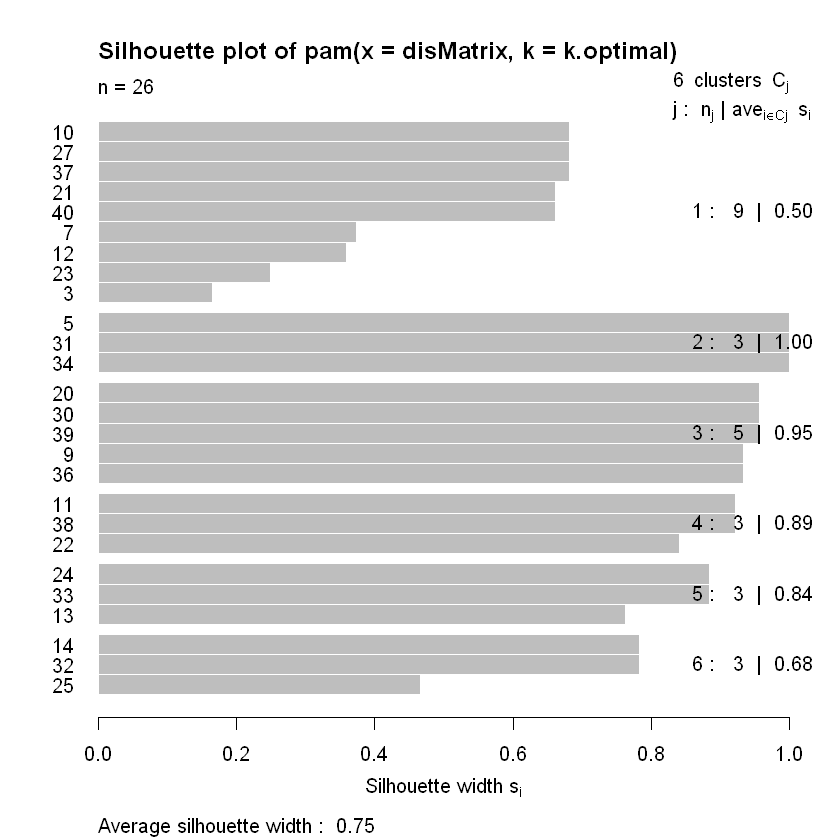

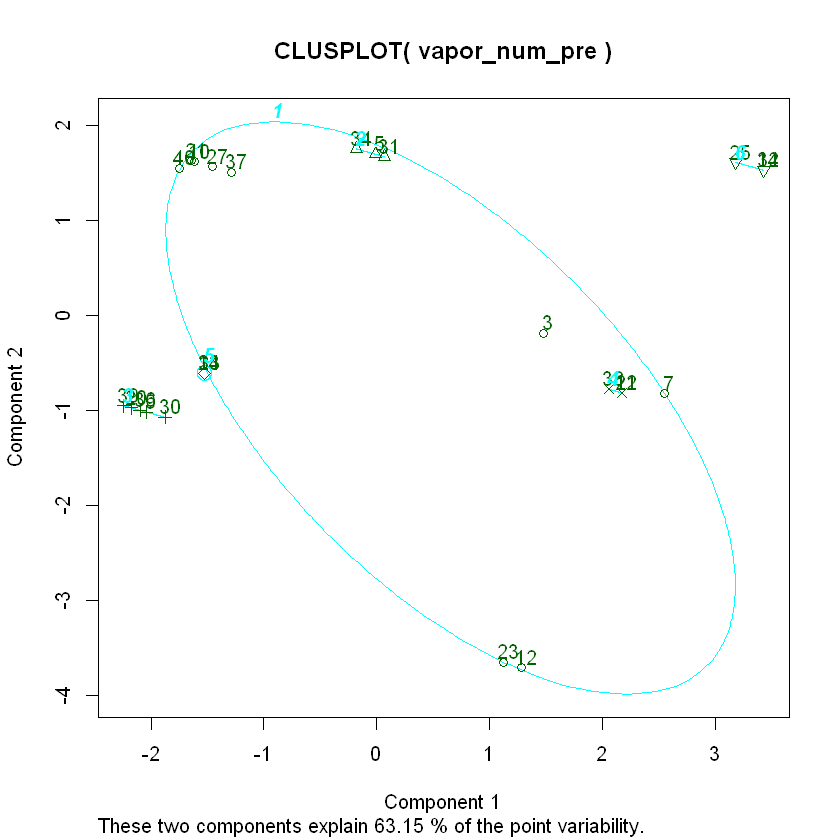

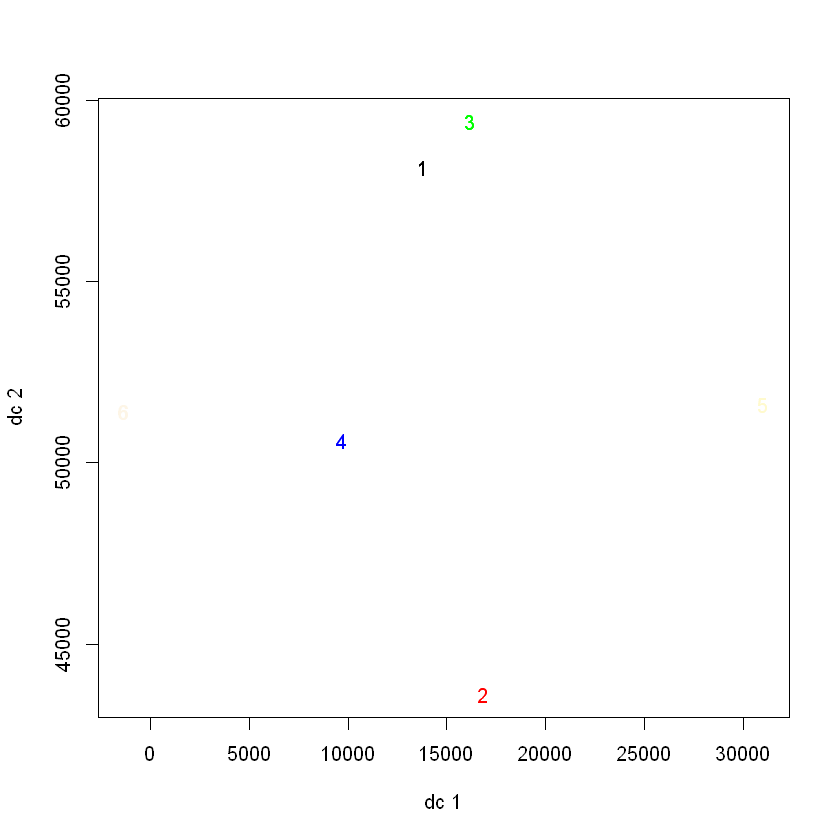

In [144]:
library(fpc)
respam_optimal=pam(disMatrix,k.optimal)
plot(respam_optimal)
vapor_pre_sans_res_num=subset(vapor_num_pre[which(vapor_num_pre$Residu_post_mictionnel != ""),])
clusplot(vapor_num_pre, respam_optimal$clustering, labels=2, lines=0)
plotcluster(vapor_num_pre,t(respam_optimal$clustering))
points(respam_optimal$medoids,col=1:11,pch=8)

### 2.1.2 CAH

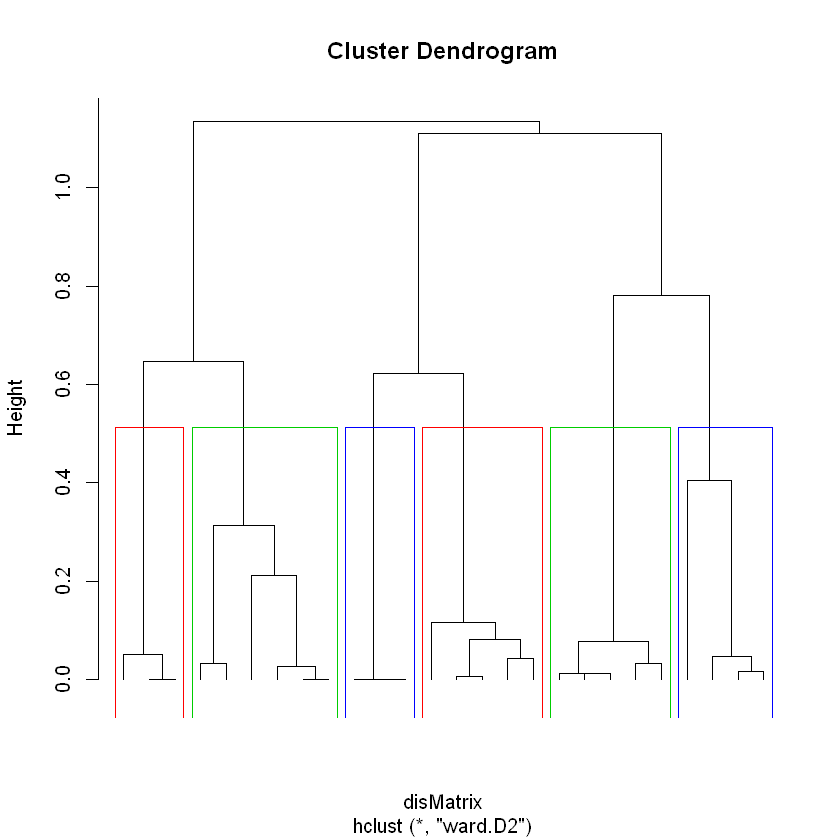

In [23]:
resuhc <- hclust(disMatrix, method = "ward.D2")
# Visualization de resuhc
plot(resuhc, labels = FALSE, hang = -1)
# Ajout des rectangles autour des clusters
rect.hclust(resuhc, k = k.optimal, border = 2:4) 

    D'apès le dendrogramme on remarque que le choix d'un nombre de cluster égal 6 est judicieux .En effet on coupe la où la hauteur des branches est très grande.En effet la hauteur des branche nous ientifie la proximité entre les classes. Ainsi plus cette hauteur est grande plus les classes sont séparées. Ainsi la cah vient valider le résultat qu'on retrouve avec Pam et confirmer le nombre de cluster qu'on a trouvé.

### 2.1.3 Caractérisation des patients médoids

In [344]:

#Indication des médoids
medoid_pre=c()
respam=pam(disMatrix,k=k.optimal)
medoids_pre=respam$medoids
for (i in 1:length(medoids_pre)){
   medoid_pre=rbind(medoid_pre,vapor_pre[medoids_pre[i],])
    }
medoid_pre


,Age,Comorbidite,Duree_Traitement_Medical,IPSS,QoL,Qmax,PSA,Volume_Prostatique,Residu_post_mictionnel,Indication,Anesthesie,Evenement,Transfusion,Temps_Operation,Volume_Reseque,Delai_Ablation,Caillotage,Reprise_Bloc
22,68,FALSE,11,22,5,5.1,3.25,86,80,2,2,0,FALSE,52,48,2,FALSE,FALSE
5,65,FALSE,12,29,6,5.3,3.40,150,50,5,1,0,FALSE,75,100,3,FALSE,FALSE
20,73,FALSE,72,20,6,9.0,4.57,166,180,2,2,0,FALSE,75,65,4,FALSE,FALSE
10,63,FALSE,120,26,5,8.5,4.15,126,200,2,1,0,FALSE,49,80,5,TRUE,FALSE
33,74,TRUE,72,24,5,6.6,7.41,119,0,2,1,0,FALSE,61,82,4,TRUE,TRUE
32,58,TRUE,21,26,5,2.4,1.15,78,0,2,1,0,FALSE,49,47,3,FALSE,FALSE


Ainsi  grace à létude ci dessus et à l'ap faite préscedemment on remarque que les patients medoids se caractérisent particulièrement par leur âge ,la durée de traitement médical,le volume prostatique, le residu post mictionnel et le volume réséqué.
Cependant on peut caractériser chacune des classes trouvées: 

->Classes d'individus  moyennement agés

-La première classe représente des individus moyennement agés qui ont à peu prés 63 ans avec un volume prostatique moyen ,une durée de traitement médical assez grande ,un residu post mictionnel  trés grand et un volume réséqué moyen.

-La seconde classe représente des individus également moyennement agés qui ont à peu prés 65 ans avec un volume prostatique trés grand , une durée de traitement médical trés faible , un résidu post mictionnel moyen  et un volume réséqué trés grand.     

-La trosième classe reprsénte des individus un peu plus agés que les deux première classes qui ont autour de 68 ans avec un volume prostatique moyen, une durée de traitement médical trés faible , un residu post mictionnel moyen et un volume réséqué petit.

->Classes d'individus  moyennement agés

-La quatrième classe représente des individus agés ayant autour de 73 ans avec un volume prostatique trés grand une durée de traitement moyenne,un résidu post mictionnel trés grand et un volume réséqué moyen voir petit.


-La cinquième classe repésente des individus ayant approximativement le même age que ceux de la classes précédente avec un volume prostatique moyen une durée de traitement moyenne et un résidu post mictionnel à zéro et un volume réséqué  moyen.

->Classe d'individu les plus jeunes

-La dernière classe représnte les individus les plus jeunes ayant autour de 58 ans avec un volume prostatique assez petit, une durée de traitement faible ,un résidu post mictionnel à zéro et un volume réséqué petit.


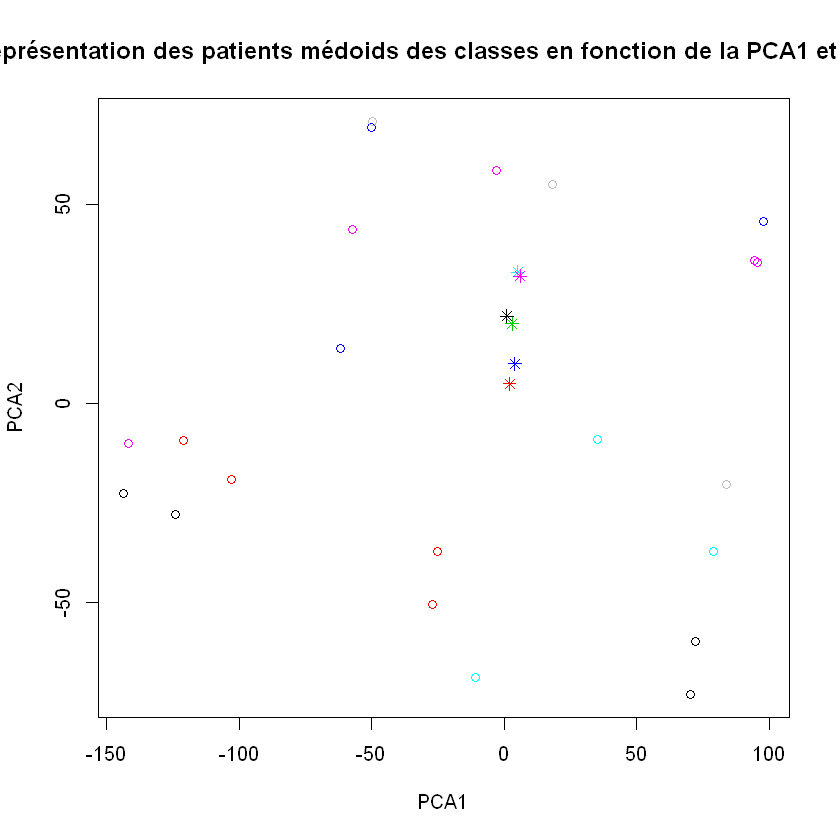

In [341]:
#On choisit un k optimal pour poursuivre notre étude et on essaye de faire pam dessus et de dessiner nos classes utilisant une acp
plot(pca$x[,1],pca$x[,2],col=respam$medoids,xlab="PCA1",ylab="PCA2",main="Représentation des patients médoids des classes en fonction de la PCA1 et PCA2 ")
points(respam$medoids,col=1:6,pch=8)

### 2.1.4 Visualtisation des distributions du Q_max à 12 mois pour les différentes classes

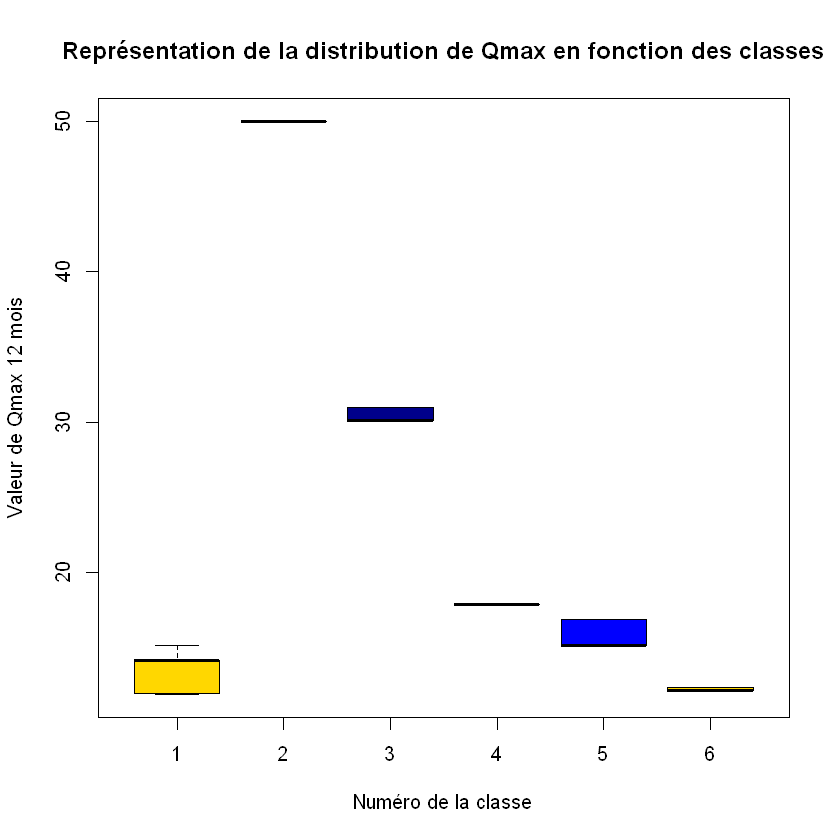

In [347]:
clusters=respam_optimal$clustering
Boxplot2=matrix(NA,ncol=2,nrow=10)
for(i in 1:6){
    clust=vapor_num_post$X12M_Qmax[which(clusters==i)]
    for (j in 1:length(clust)){
       Boxplot2[j,2]=clust[j]
        Boxplot2[j,1]=i
}
Boxplot2=rbind(Boxplot2,Boxplot2)
}

boxplot(Boxplot2[,2]~Boxplot2[,1], main="Représentation de la distribution de Qmax en fonction des classes", col=(c("gold","darkgreen","darkblue","red","blue")), ,xlab="Numéro de la classe", ylab="Valeur de Qmax 12 mois")

On remarque que pour la première ,la 5ième et la 3ime classe les valeurs de Q_max ne sont pas très homogènes entre les individus comme pour la 2ième,4ième et 6ièe classes ou les valeurs de Q_max sont toutes trés proches les unes des autres. 

On peut également visualiser chacun de ses Q_max de chaque classe indépendamment des autres pour avoir une vision plus claire sur lesdifférentes valeurs.

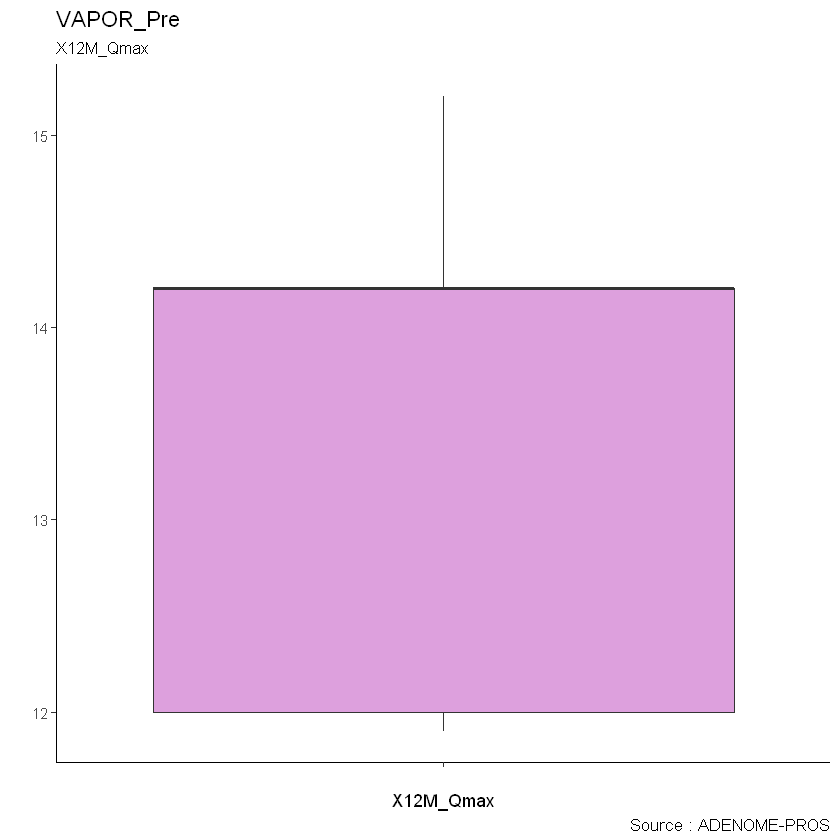

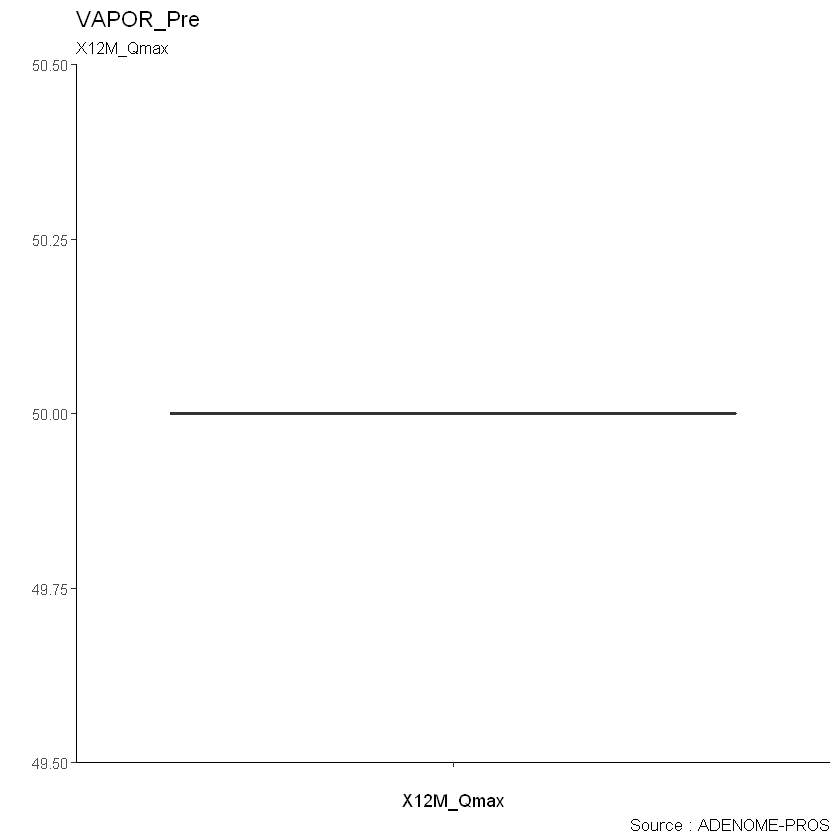

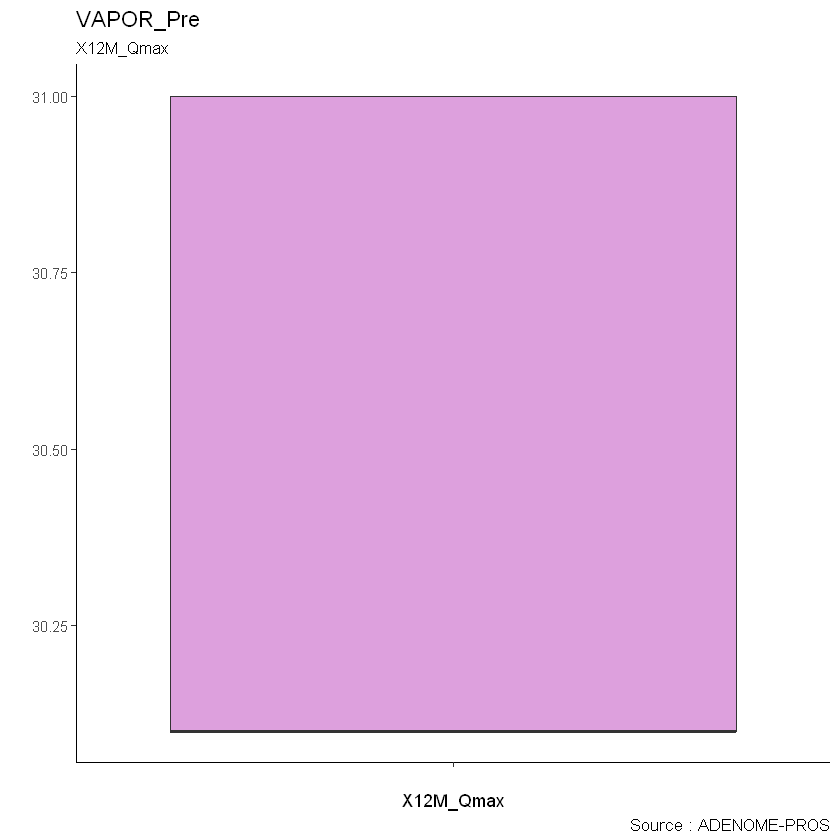

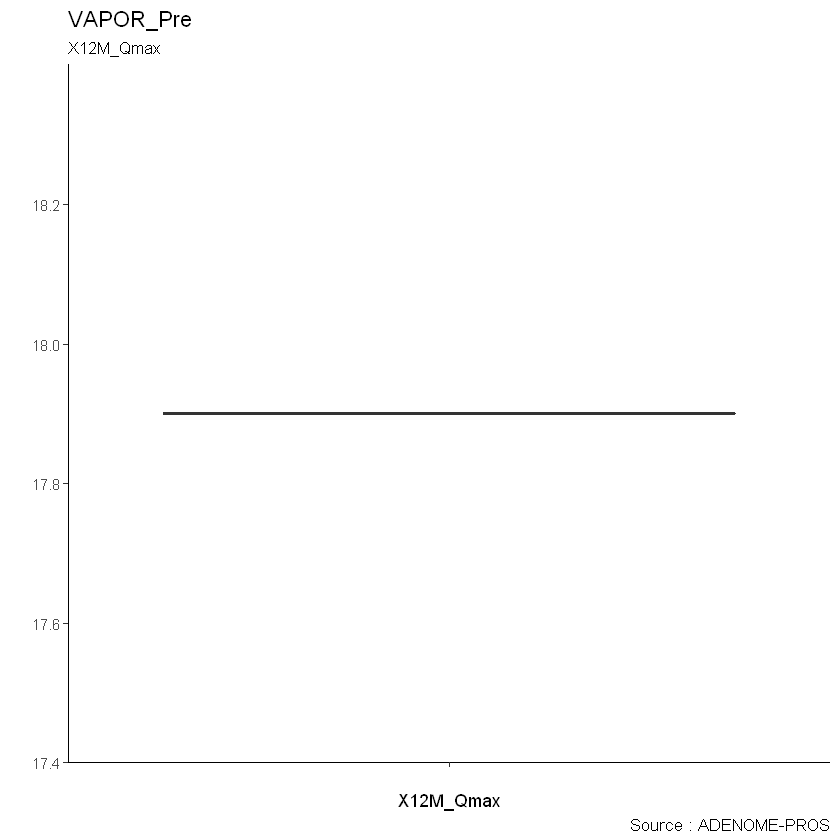

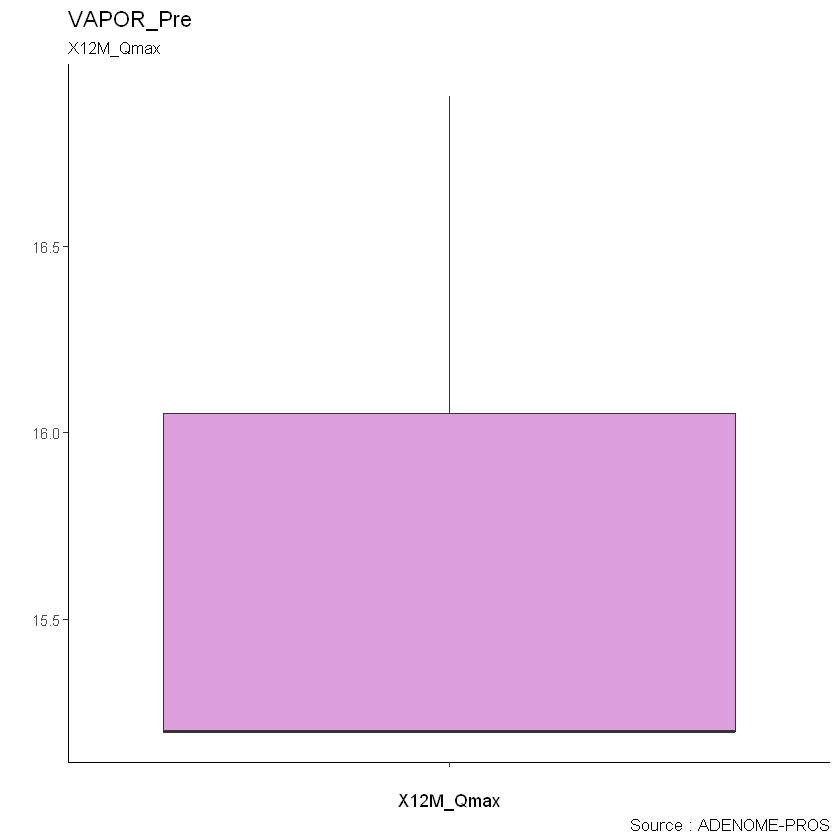

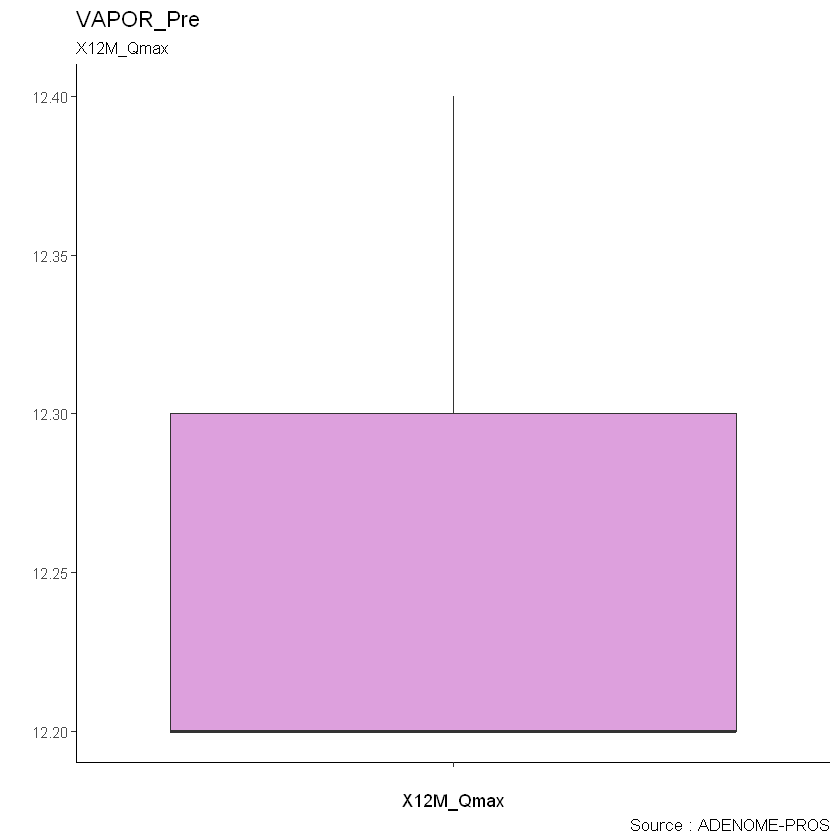

In [215]:
clusters=respam_optimal$clustering
for(i in 1:k.optimal){
    clust=which(clusters==i)
    adenome_boxplot(vapor_post[clust,],15,"VAPOR_Pre")
    }


## 2.2 Extraction des profils types des patients à partir des données post-opératoires
### 2.2.1 PAM

In [403]:
#On crée une matrice de séries temporelles
vapor_cat_post$X1M_QoL<-as.numeric(vapor_cat_post$X1M_QoL)
vapor_cat_post$X3M_QoL<-as.numeric(vapor_cat_post$X3M_QoL)
vapor_cat_post$X6M_QoL<-as.numeric(vapor_cat_post$X6M_QoL)
vapor_cat_post$X9M_QoL<-as.numeric(vapor_cat_post$X9M_QoL)
vapor_cat_post$X12M_QoL<-as.numeric(vapor_cat_post$X12M_QoL)
vapor_cat_post$X15M_QoL<-as.numeric(vapor_cat_post$X15M_QoL)
vapor_cat_post$X18M_QoL<-as.numeric(vapor_cat_post$X18M_QoL)
vapor_cat_post_QoL=t(vapor_cat_post)
vapor_cat_post_series_QoL=ts(vapor_cat_post_QoL, start=1,deltat=3)
matrix_series=matrix(NA,ncol=21)
matrix_series=cbind(t(vapor_num_post_series_qmax),t(vapor_num_post_series_ipss))
matrix_series=cbind(matrix_series,(t(vapor_cat_post_series_QoL)))

In [405]:

#On crée une matrice de dissimilarité utilisant la distance euclidienne
disMatrix=dist(matrix_series , method="euclidean")
#On fait une boucle pour repèrer les 5 meilleurs valeurs de k qui maximise la valeur silhouette
respam<- numeric(20)
for (k in 2:11)
respam[[k]] <- pam(disMatrix,k) $ silinfo $ avg.width
sortrespam=respam[which(respam>0.7)]
sortrespam=sort(sortrespam,decreasing=TRUE)
for (i in 1:5){
    if(i <= length(sortrespam))
    k.best[i] <-which(respam[]==sortrespam[i])
}
#On regarde le min de k pour une valeur silhouette supérieur à 0.7
k.min<-min(k.best)
cat("Les 5 meilleurs nombre de clusters sont", k.best, ".Ayant une valeur silhouette de ",respam[k.best[1]]," pour un nombre de cluster=" ,k.best[1]," . \n")
cat("Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est", k.min, " et ayant un valeur silhouette de ",respam[k.min],"\n")



Les 5 meilleurs nombre de clusters sont 11 10 6 3 9 10 .Ayant une valeur silhouette de  0.8018298  pour un nombre de cluster= 11  . 
Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est 3  et ayant un valeur silhouette de  0.7438339 


In [406]:
k.optimal=k.min

On choisit le minimum de classes c'est à dire trois classes puis on fait la CAH afin de valider le résultat trouvé.

### 2.2.2 CAH

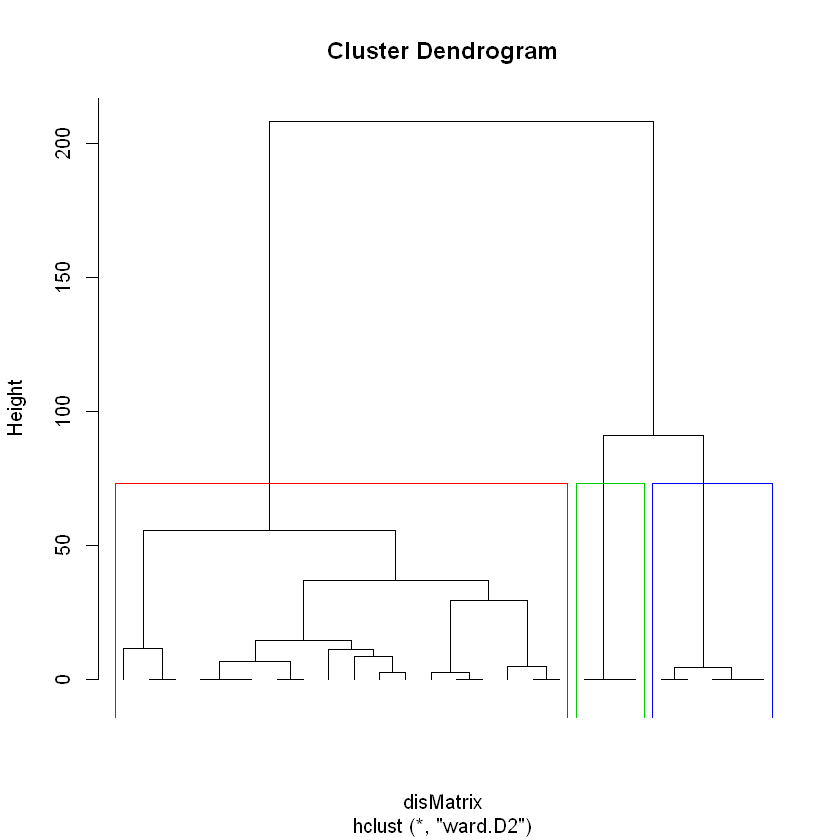

In [402]:
resuhc <- hclust(disMatrix, method = "ward.D2")
# Visualization de resuhc
plot(resuhc, labels = FALSE, hang = -1)
# Ajout des rectangles autour des clusters
rect.hclust(resuhc, k = k.optimal, border = 2:4) 

In [ ]:
Ainsi en faisant la CAH on remarque que les classes ne sont pas trés homogènes. Le nombre d'individus dans chaque classe est trés différent d'une classe à une autre ainsi on peut faire une étude cah pour un cluster=6.

La CAH permet de bien valider le nombre de clusters trouvé en faisant l'étude PAM ainsi on retrouve 6 classes différentes.

### 2.2.3 Caractérisation des patients médoids

Medoids:
     ID       
[1,] "1"  "3" 
[2,] "21" "34"
[3,] "25" "39"
Clustering vector:
 3  5  7  9 10 11 12 13 14 20 21 22 23 24 25 27 30 31 32 33 34 36 37 38 39 40 
 1  2  1  3  1  1  1  1  1  3  1  1  1  1  1  1  3  2  1  1  2  3  1  1  3  1 
Objective function:
    build      swap 
11.206592  8.956903 

Available components:
[1] "medoids"    "id.med"     "clustering" "objective"  "isolation" 
[6] "clusinfo"   "silinfo"    "diss"       "call"      


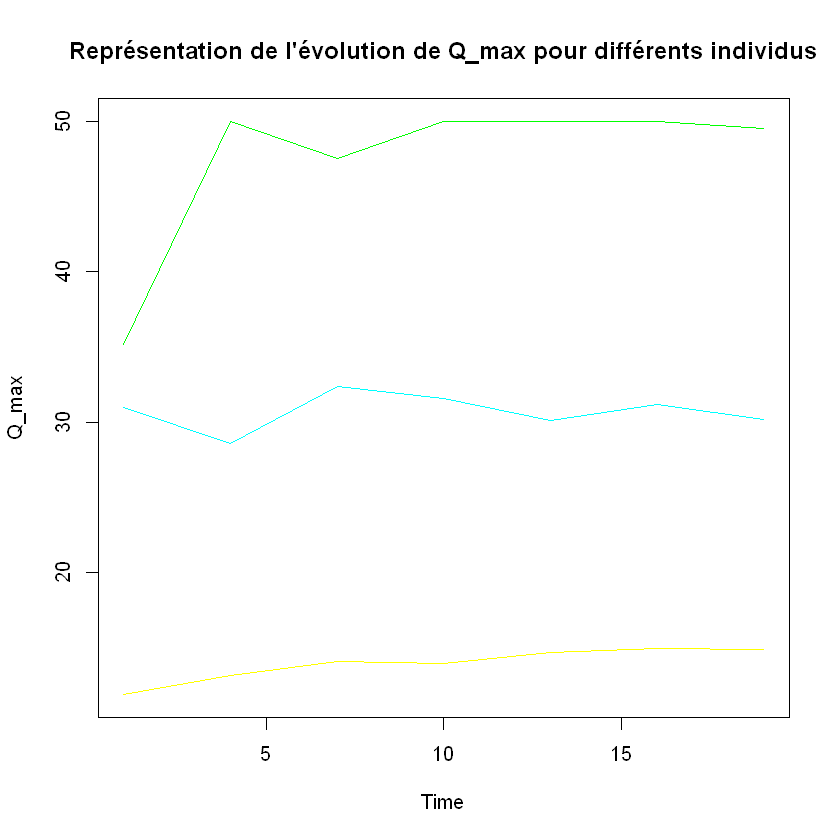

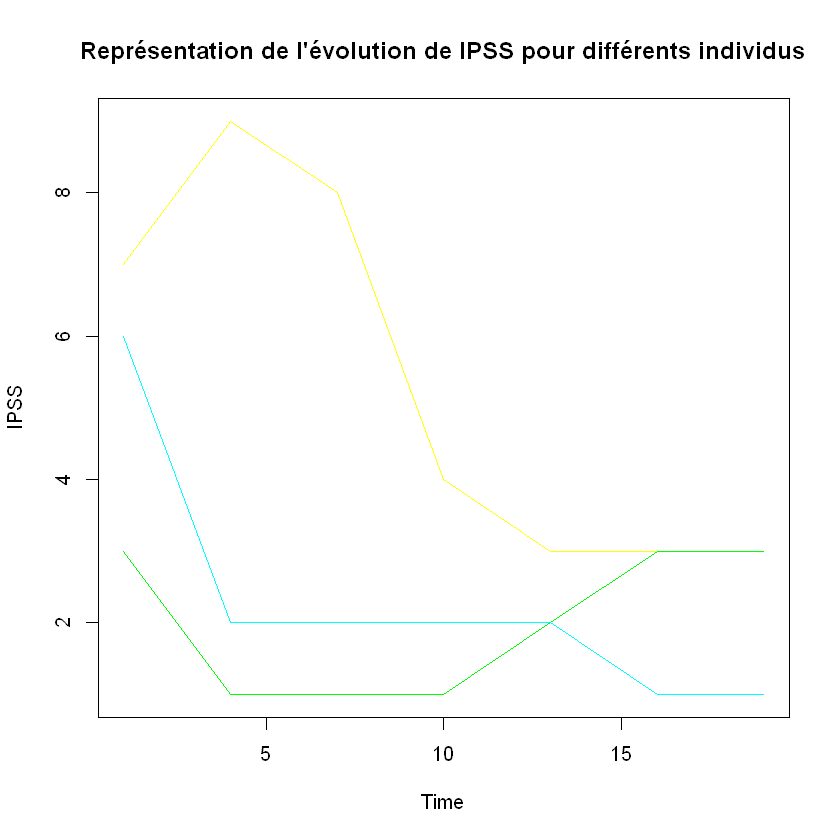

In [410]:
#Indication des médoids
medoid_post=c()
Q_max_medoids=matrix(NA)
Ipss_medoids=matrix(NA)
medoids_post=pam(disMatrix,k=k.optimal)$medoids
print(pam(disMatrix,k=k.optimal))
resdtw=matrix(NA)
for (i in 1:length(medoids_post)){
    medoid_post=rbind(medoid_post,vapor_post[medoids_post[i],])
    Q_max_medoid=vapor_num_post_series_qmax[,medoids_post[i]] 
    Ipss_medoid=vapor_num_post_series_ipss[,medoids_post[i]] 
    Q_max_medoids=cbind(Q_max_medoids,Q_max_medoid)
    Ipss_medoids=cbind(Ipss_medoids,Ipss_medoid)
}

ts.plot(Q_max_medoids,gpars= list(col=rainbow(6)),ylab= "Q_max",main="Représentation de l'évolution de Q_max pour différents individus")

ts.plot(Ipss_medoids,gpars= list(col=rainbow(6)),ylab= "IPSS",main="Représentation de l'évolution de IPSS pour différents individus")


# 3.Classification Supervisée

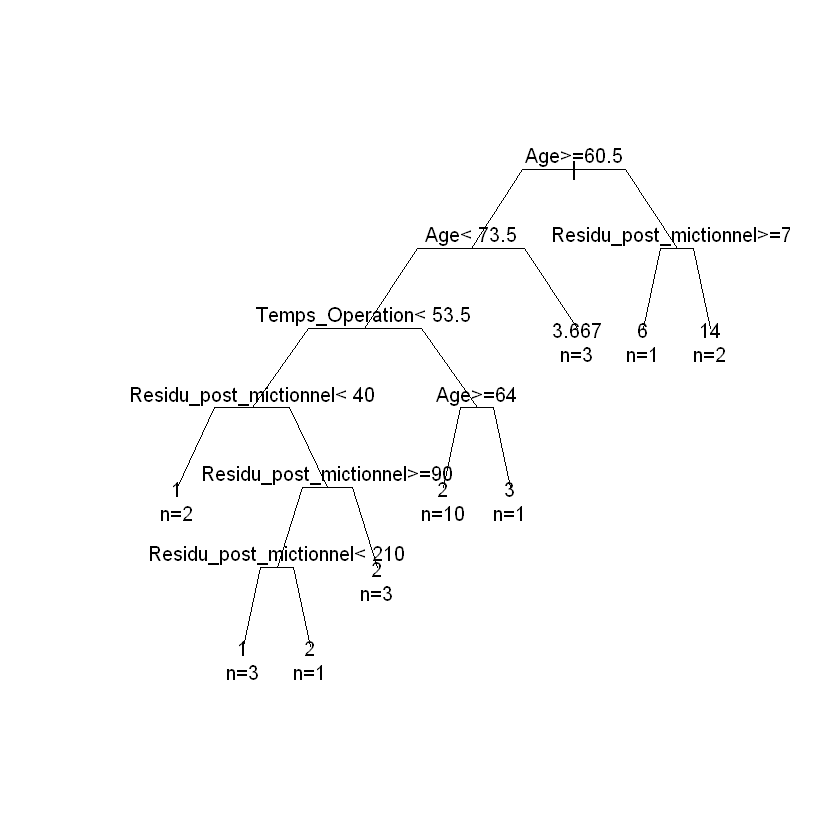

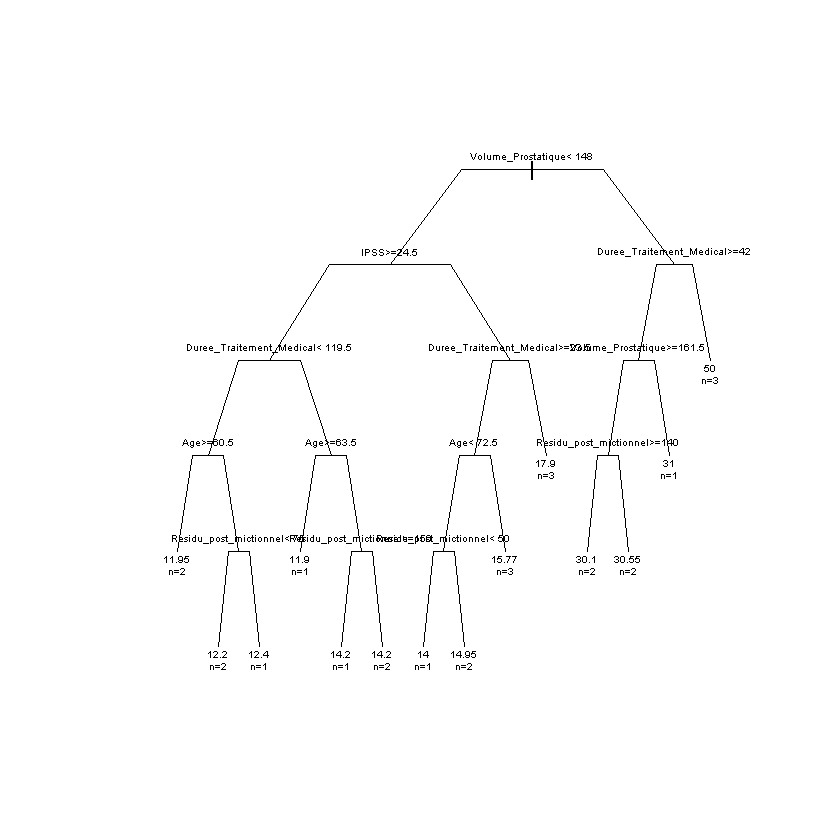

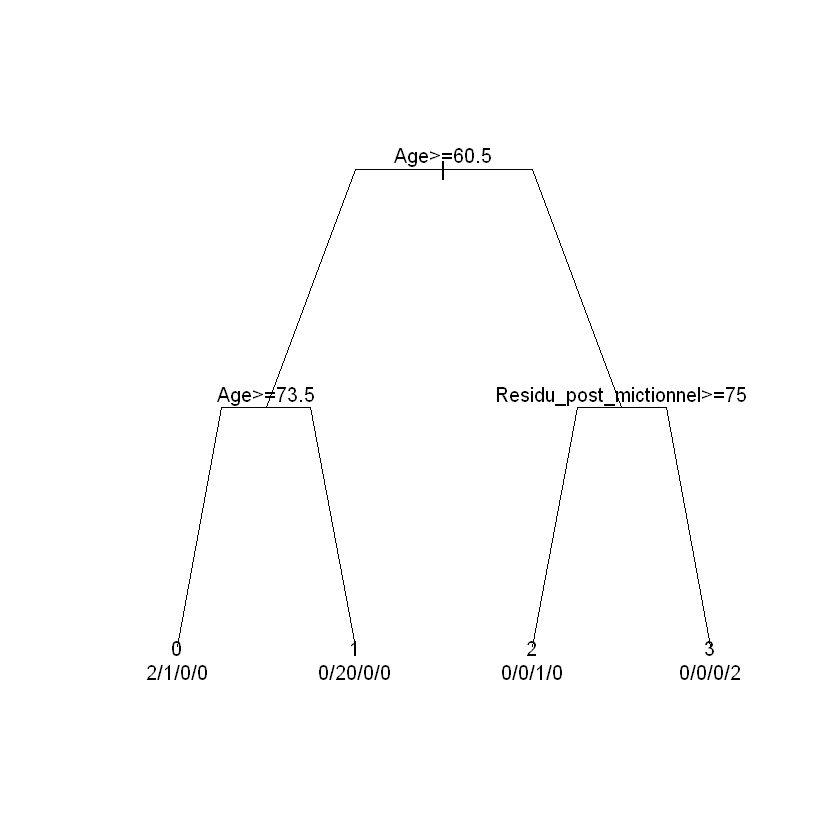

In [158]:
IPSS=c()
matrix_for_tree=matrix(NA)
ipss=subset(vapor_num_post,select=c(X12M_IPSS))
qol=subset(vapor_cat_post,select=c(X12M_QoL))
qmax=subset(vapor_num_post,select=c(X12M_Qmax))
matrix_for_tree_IPSS=cbind(vapor_num_pre,ipss)
matrix_for_tree_QoL=cbind(vapor_num_pre,qol)
matrix_for_tree_Qmax=cbind(vapor_num_pre,qmax)
tree_IPSS=rpart(matrix_for_tree_IPSS$X12M_IPSS ~.,data=matrix_for_tree_IPSS,control=rpart.control(minsplit=2,cp=0))
tree_Qmax = rpart(matrix_for_tree_Qmax$X12M_Qmax ~ .,data=matrix_for_tree_Qmax,control=rpart.control(minsplit=3,cp=0))
tree_QoL = rpart(matrix_for_tree_QoL$X12M_QoL ~ .,data=matrix_for_tree_QoL,control=rpart.control(minsplit=1,cp=0))
plot(tree_IPSS, uniform=TRUE, branch=0.5, margin=0.1)
text(tree_IPSS, all=FALSE, use.n=TRUE)
plot(tree_Qmax, uniform=TRUE, branch=0.5, margin=0.1)
text(tree_Qmax, all=FALSE, use.n=TRUE,cex=.5)
plot(tree_QoL, uniform=TRUE, branch=0.5, margin=0.1)
text(tree_QoL, all=FALSE, use.n=TRUE)